<a href="https://colab.research.google.com/github/ManjuKannavalli/RIO-210_Forecasting_system_project_Manjunath/blob/main/RIO_210_Forecasting_system_project_Manjunath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting System - Project Demand of Products at a Retail Outlet Based on historical data

In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

!pip install Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#pd.set_option("display.max_columns", 9994)
df = pd.read_excel("/content/drive/My Drive/TCS iON RIO 210 Internship/Sample - Superstore.xls")
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]


##Exploratory Data Analysis

In [4]:
df.shape

(9994, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [6]:
df.corr()['Sales']

Row ID        -0.001359
Postal Code   -0.023854
Sales          1.000000
Quantity       0.200795
Discount      -0.028190
Profit         0.479064
Name: Sales, dtype: float64

### The correlation between Quantity,Discount, Profit against Sales is not strong.

##Indexing Data

In [7]:
df = df.set_index(['Order Date'])

In [8]:
df.index.min()

Timestamp('2014-01-03 00:00:00')

In [9]:
df.index.max()

Timestamp('2017-12-30 00:00:00')

####Points to Remember:
- The sample dataset used is the data from 2014 to 2017
- It has 9994 rows and 21 columns/values
-It has periodic data. Hence its a times series data
- Scope is finding the forecast for sales data against order data with existing product categories

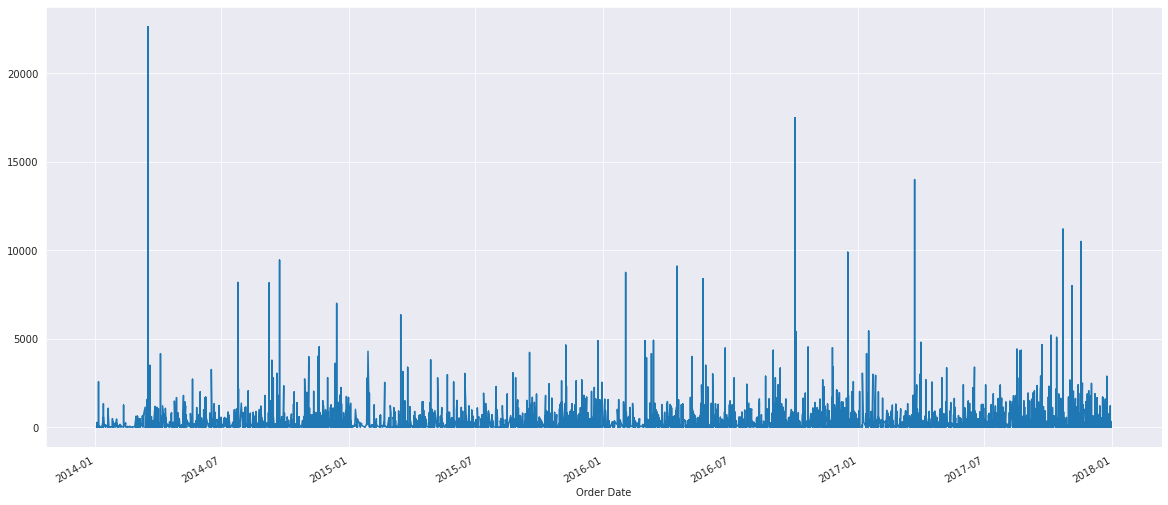

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9
df['Sales'].plot();

####Average/Mean monthly sales

Order Date
2014-01-01    180.213861
2014-02-01     98.258522
2014-03-01    354.719803
2014-04-01    209.595148
2014-05-01    193.838418
2014-06-01    256.260204
2014-07-01    237.387364
2014-08-01    182.414827
2014-09-01    305.139369
2014-10-01    197.820082
2014-11-01    247.260115
2014-12-01    250.164103
2015-01-01    313.346131
2015-02-01    186.740797
2015-03-01    280.625014
2015-04-01    213.720053
2015-05-01    206.381414
2015-06-01    179.690522
2015-07-01    205.466607
2015-08-01    232.064982
2015-09-01    220.463884
2015-10-01    189.186286
2015-11-01    234.483221
2015-12-01    237.087092
2016-01-01    208.342596
2016-02-01    276.853193
2016-03-01    317.275307
2016-04-01    227.941406
2016-05-01    253.278791
2016-06-01    202.736352
2016-07-01    195.333149
2016-08-01    176.791899
2016-09-01    202.231474
2016-10-01    304.529311
2016-11-01    214.626935
2016-12-01    275.565463
2017-01-01    283.686284
2017-02-01    189.730219
2017-03-01    247.362827
2017-04-01    

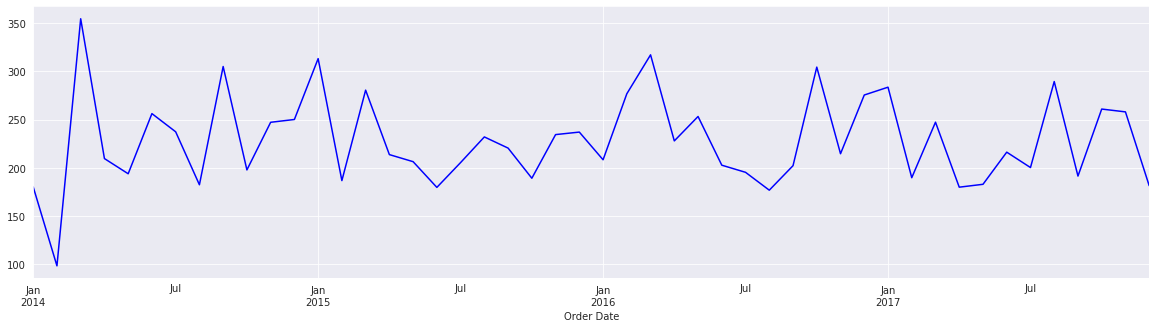

In [11]:
monthly_mean_sales = df.resample(rule='MS').mean()['Sales']
print(monthly_mean_sales)
monthly_mean_sales.plot(figsize=(20,5),c='blue')
plt.show()

 #### Note:
 - Mean monthly sales is maximum in month march 2014. 
 - Also on month sep 2014, jan 2015, march 2016, oct 2016 shows significant higher sales.
 - There is a sales drop during feb 2014.
 - ARIMA model is good choice as there is seasonality factor along with other trends.

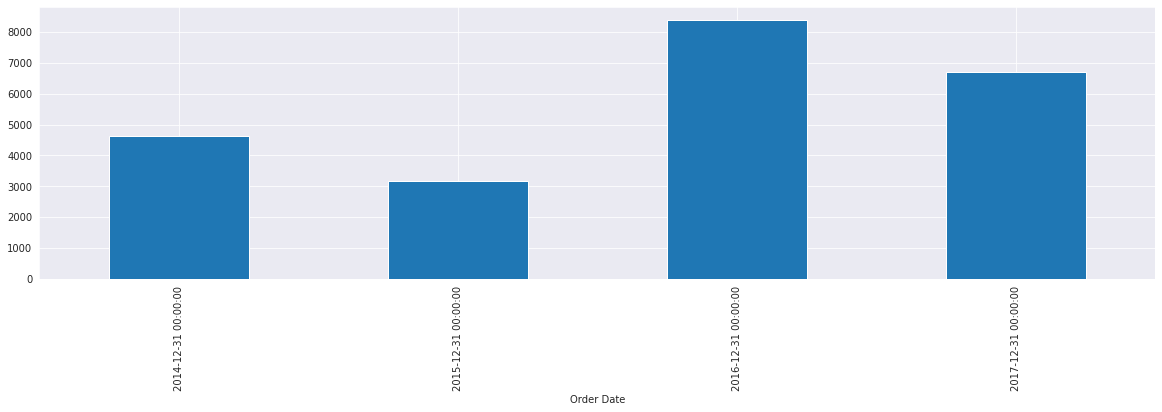

In [12]:
df.resample(rule='A').max()['Profit'].plot(kind='bar',figsize=(20,5))
plt.show()

## Data Pre-processing

In [13]:
#Identify the categories in the dataset
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [14]:
#Finding out whether missing values are in the dataset or not
df.isna().sum()

Row ID           0
Order ID         0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

#####Note: The dataset is clean and it doesn't contain any null/missing values

In [15]:
#checking for distinct/unique values in each columns
{column:len(df[column].unique()) for column in df.columns}

{'Row ID': 9994,
 'Order ID': 5009,
 'Ship Date': 1334,
 'Ship Mode': 4,
 'Customer ID': 793,
 'Customer Name': 793,
 'Segment': 3,
 'Country': 1,
 'City': 531,
 'State': 49,
 'Postal Code': 631,
 'Region': 4,
 'Product ID': 1862,
 'Category': 3,
 'Sub-Category': 17,
 'Product Name': 1850,
 'Sales': 6144,
 'Quantity': 14,
 'Discount': 12,
 'Profit': 7545}

In [16]:
df = df.copy()
col = ['Row ID',
       'Country',
       'Customer Name',
       'Product Name',
       'Order ID',
       'Customer ID',
       'Ship Date',
       'Ship Mode',
       'Segment',
       'City',
       'State',
       'Postal Code',
       'Region',
       'Product ID',
       'Sub-Category',
       'Quantity',
       'Discount',
       'Profit']
df.drop(col,axis=1, inplace=True)

In [17]:
df.shape

(9994, 2)

#### Since dataset contain multiple categories of products we have to create seperate Dataframes for each category for analysis.

#Furniture Dataframe

In [18]:
#creating the dataframe where category is furniture
furniture_df = df.loc[df['Category'] == 'Furniture']
furniture_df

Category      Sales
Order Date                      
2016-11-08  Furniture   261.9600
2016-11-08  Furniture   731.9400
2015-10-11  Furniture   957.5775
2014-06-09  Furniture    48.8600
2014-06-09  Furniture  1706.1840
...               ...        ...
2015-03-19  Furniture   383.4656
2016-12-05  Furniture    13.4000
2015-09-06  Furniture    85.9800
2014-01-21  Furniture    25.2480
2017-02-26  Furniture    91.9600

[2121 rows x 2 columns]

In [19]:
furniture_df.drop('Category',axis=1, inplace=True)
furniture_df.head()

Sales
Order Date           
2016-11-08   261.9600
2016-11-08   731.9400
2015-10-11   957.5775
2014-06-09    48.8600
2014-06-09  1706.1840

In [20]:
#sorting by order date
furniture_df = furniture_df.sort_values('Order Date')
furniture_df

Sales
Order Date          
2014-01-06  2573.820
2014-01-07    76.728
2014-01-10    51.940
2014-01-11     9.940
2014-01-13   545.940
...              ...
2017-12-29   258.750
2017-12-29  1207.840
2017-12-29   101.120
2017-12-29   300.980
2017-12-30   323.136

[2121 rows x 1 columns]

In [21]:
furniture_df.describe()

Sales
count  2121.000000
mean    349.834887
std     503.179145
min       1.892000
25%      47.040000
50%     182.220000
75%     435.168000
max    4416.174000

In [22]:
furniture_df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [23]:
#looking for average monthly sales of customers
y_furniture = furniture_df['Sales'].resample('MS').mean()

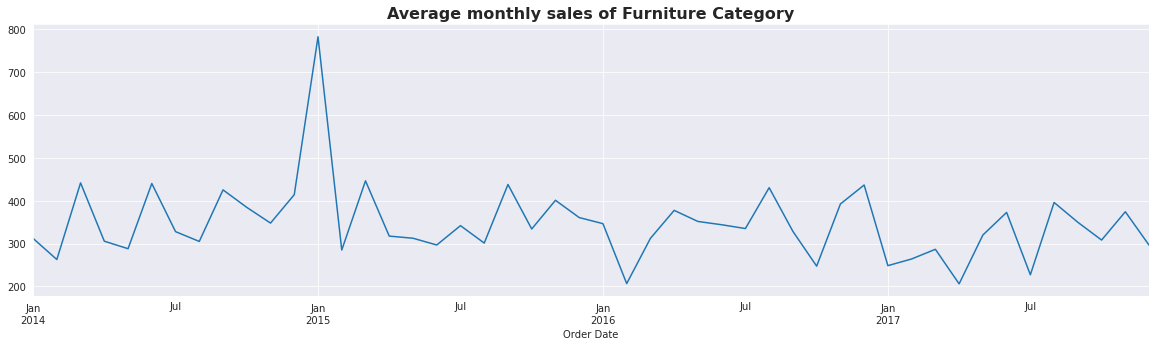

In [24]:
#investigating the average monthly sales of furnitures
y_furniture.plot(figsize=(20,5))
plt.title('Average monthly sales of Furniture Category',fontsize=16,fontweight='bold')
plt.show()

Note: Average sales is maximum at Jan 2015.

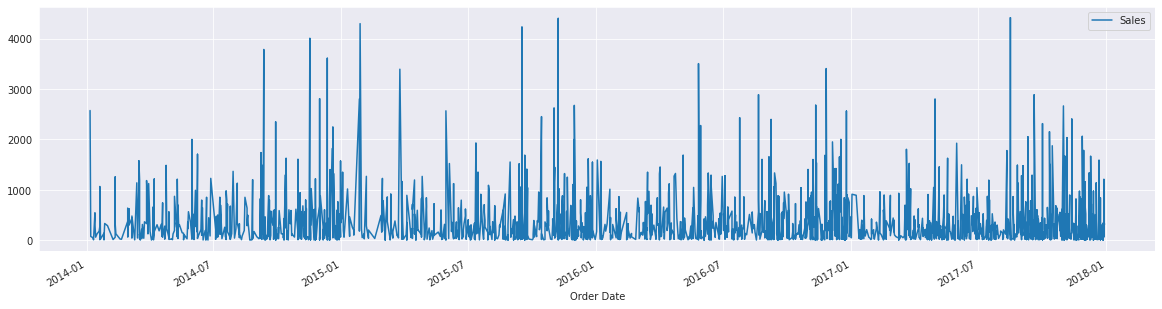

In [25]:
furniture_df.plot(figsize=(20,5))
plt.show()

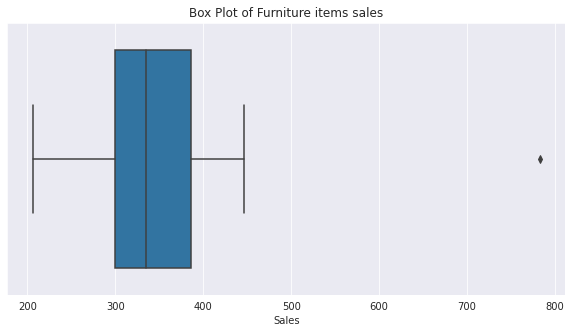

In [26]:
#Validate for outliers/bad data
import seaborn as sns
fig = plt.figure(figsize=(10,5))
sns.boxplot(y_furniture).set_title('Box Plot of Furniture items sales')
plt.show()

It is evident that there is outlier in Furniture sales data

### Office Supplies

In [27]:
office_supplies_data = df.loc[df['Category'] == 'Office Supplies']
office_supplies_data

Category    Sales
Order Date                          
2016-06-12  Office Supplies   14.620
2015-10-11  Office Supplies   22.368
2014-06-09  Office Supplies    7.280
2014-06-09  Office Supplies   18.504
2014-06-09  Office Supplies  114.900
...                     ...      ...
2016-09-22  Office Supplies   35.560
2015-05-17  Office Supplies   31.500
2015-05-17  Office Supplies   55.600
2017-02-26  Office Supplies   29.600
2017-05-04  Office Supplies  243.160

[6026 rows x 2 columns]

In [28]:
office_supplies_data.drop('Category',axis=1, inplace=True)

In [29]:
office_supplies_data = office_supplies_data.sort_values('Order Date')
office_supplies_data.head()

Sales
Order Date         
2014-01-03   16.448
2014-01-04  272.736
2014-01-04   11.784
2014-01-04    3.540
2014-01-05   19.536

In [30]:
office_supplies_data.describe()

Sales
count  6026.000000
mean    119.324101
std     382.182228
min       0.444000
25%      11.760000
50%      27.418000
75%      79.920000
max    9892.740000

In [31]:
office_supplies_data.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-04', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-06', '2014-01-06',
               '2014-01-06', '2014-01-06',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30', '2017-12-30', '2017-12-30',
               '2017-12-30', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=6026, freq=None)

In [32]:
y_office = office_supplies_data['Sales'].resample('MS').mean()

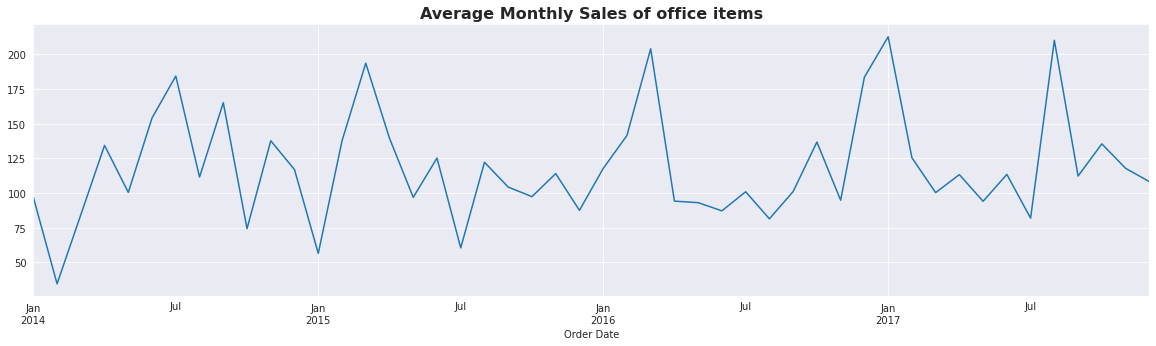

In [33]:
y_office.plot(figsize = (20,5))
plt.title('Average Monthly Sales of office items', fontsize=16, fontweight='bold')
plt.show()

Sales for office supplies shows maximum at start of year between feb to april and minimum at end of year.

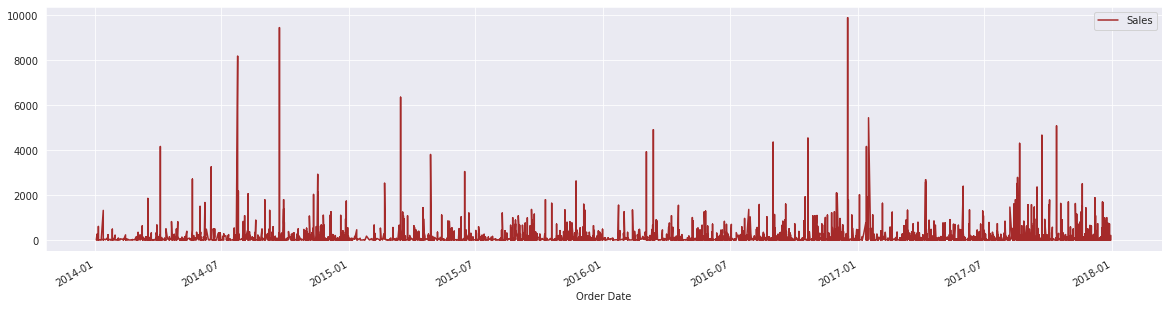

In [34]:
office_supplies_data.plot(figsize=(20,5), c = 'brown')
plt.show()

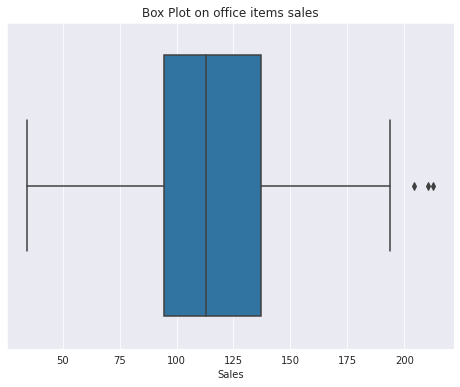

In [35]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_office).set_title('Box Plot on office items sales')
plt.show()

It is evident that there are 3 outliers in Office items sales data

## Technology items

In [36]:
technology_df = df.loc[df['Category'] == 'Technology']
technology_df

Category     Sales
Order Date                      
2014-06-09  Technology   907.152
2014-06-09  Technology   911.424
2014-08-27  Technology   213.480
2016-01-16  Technology    90.570
2016-12-08  Technology  1097.544
...                ...       ...
2016-09-22  Technology    97.980
2016-09-29  Technology    36.240
2017-11-17  Technology    79.990
2017-11-17  Technology   206.100
2017-02-26  Technology   258.576

[1847 rows x 2 columns]

In [37]:
technology_df.drop('Category',axis=1, inplace=True)

In [38]:
technology_df = technology_df.sort_values('Order Date')

In [39]:
technology_df.describe()

Sales
count   1847.000000
mean     452.709276
std     1108.655848
min        0.990000
25%       68.016000
50%      166.160000
75%      448.534000
max    22638.480000

In [40]:
technology_df.index

DatetimeIndex(['2014-01-06', '2014-01-06', '2014-01-09', '2014-01-13',
               '2014-01-15', '2014-01-16', '2014-01-20', '2014-01-26',
               '2014-01-26', '2014-02-01',
               ...
               '2017-12-24', '2017-12-24', '2017-12-25', '2017-12-25',
               '2017-12-25', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1847, freq=None)

In [41]:
technology_df.index.min()

Timestamp('2014-01-06 00:00:00')

In [42]:
technology_df.index.max()

Timestamp('2017-12-30 00:00:00')

In [43]:
y_technology = technology_df['Sales'].resample('MS').mean()

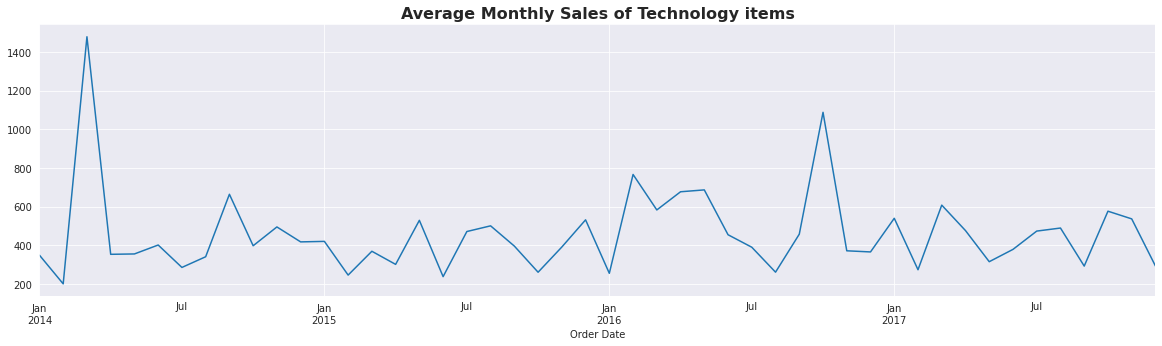

In [44]:
y_technology.plot(figsize = (20,5))
plt.title('Average Monthly Sales of Technology items', fontsize=16, fontweight='bold')
plt.show()

Clearly seen that Technology items have highest sales in march 2014 and also in oct-nov of 2016.

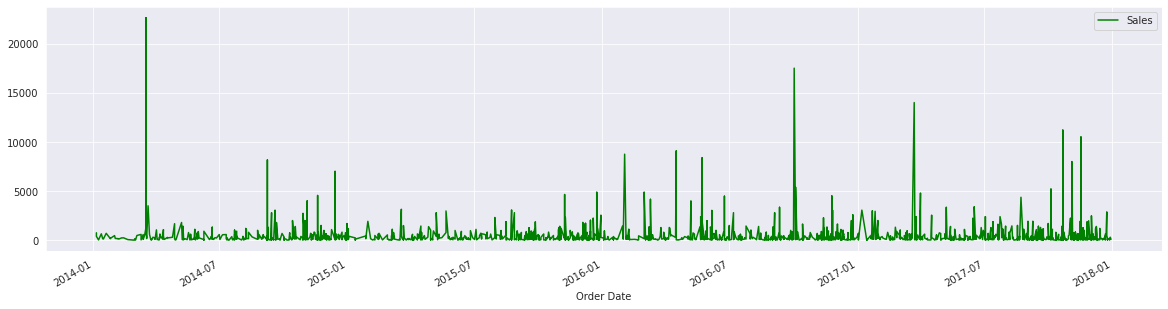

In [45]:
technology_df.plot(figsize=(20,5), c = 'green', legend = True)
plt.show()


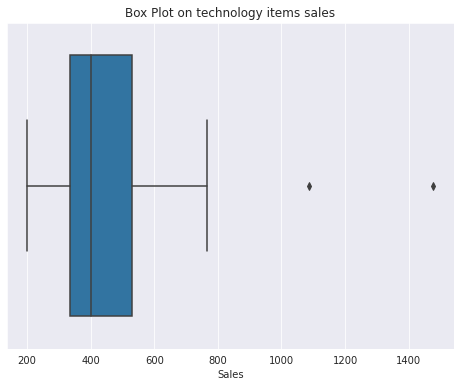

In [46]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_technology).set_title('Box Plot on technology items sales')
plt.show()

Clearly seen that there are 2 outliers for Tachnology items sales

## Seasonality determination for each category

### Furniture

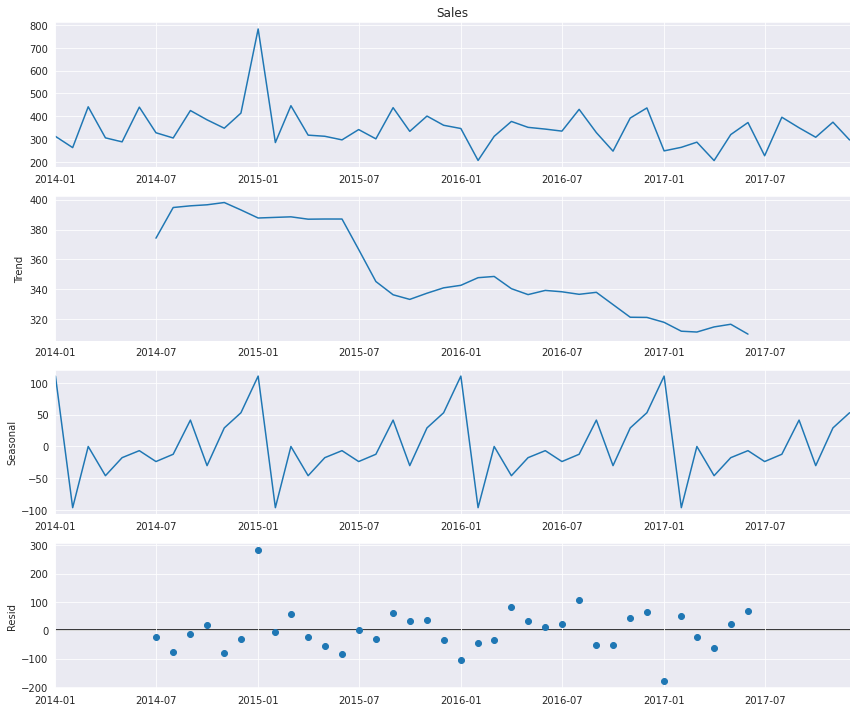

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(y_furniture, model='additive')
fig = decomposition.plot()
plt.show()

The peak demand for furniture was till 2015. There is a declining demand trend seen after that

### Office items

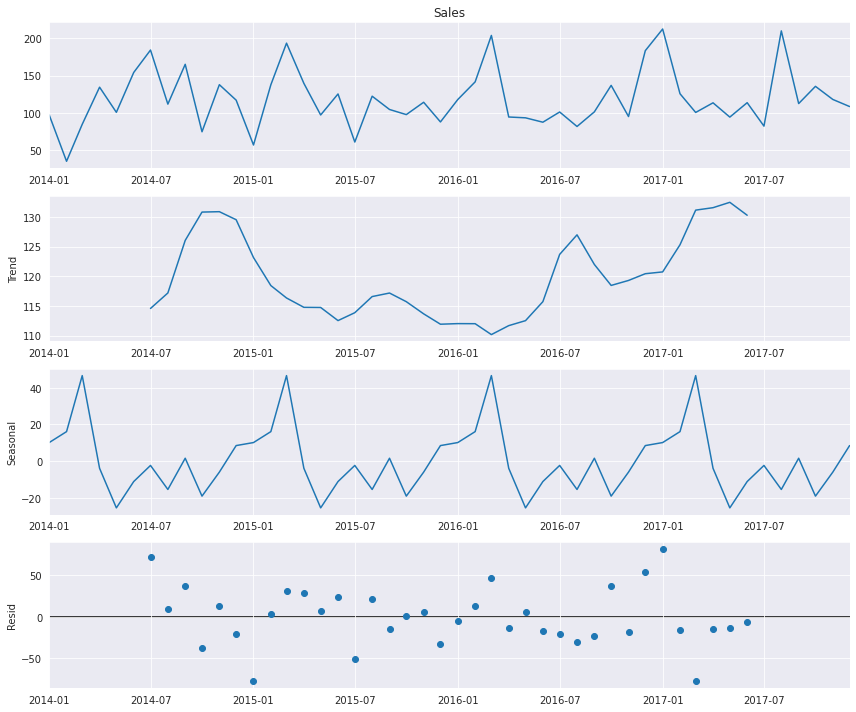

In [48]:
rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(y_office, model='additive')
fig = decomposition.plot()
plt.show()

It is very clear from the seasonal graph, that demand is higher during early months of the year, lowest in mid year and gradual increase in demand at the end of the year

### Technology

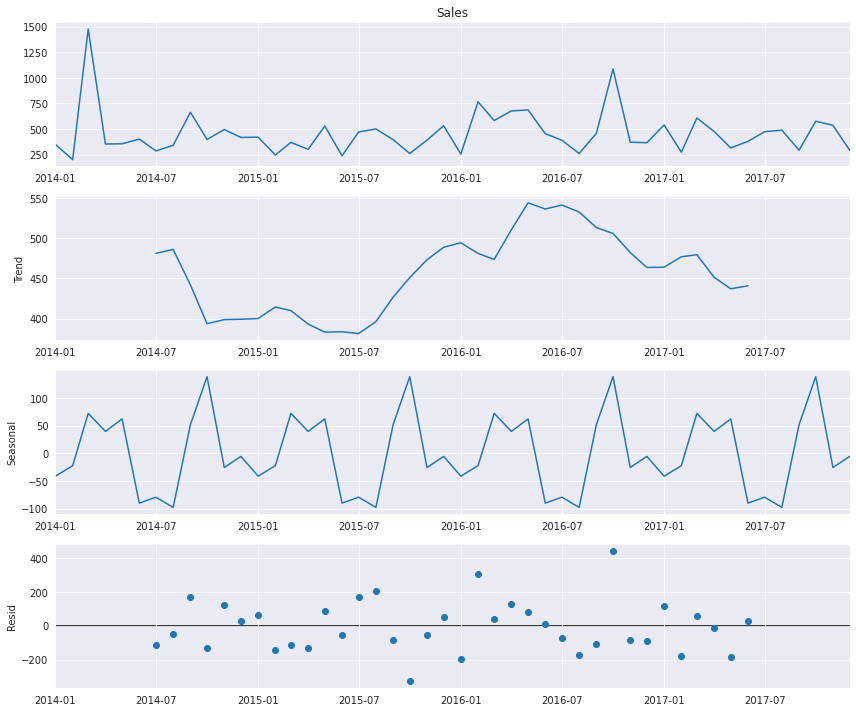

In [49]:
rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(y_technology, model='additive')
fig = decomposition.plot()
plt.show()

Demand was at peak in mid-2016 and the downward trend follows for Technology items

## Test for stationarity
###Stationarity means that the statistical properties of a time series do not change over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

#####Source - KDNuggets.com

*Augmented dickey fuller test is used to check the stationarity*

In [50]:
#H0 : data is non stationary (unit root =1)
#H1 : data is stationery (unit root <1)

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF test statistic', 'p-value', 'No. of observations used', '#lags used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, \nreject the null hypothesis. Data lacks unit root, hence stationary")
    else:
        print("weak evidence against null hypothesis, \ntime series has a unit root, hence non-stationary ")

In [51]:
print("Test of Furniture")
adfuller_test(y_furniture)
print('-'*120)
print("Test of Office Items")
adfuller_test(y_office)
print('-'*120)
print("Test of Technology")
adfuller_test(y_technology)
print('-'*120)

Test of Furniture
ADF test statistic : -6.962405221214861
p-value : 9.093398510006677e-10
No. of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, 
reject the null hypothesis. Data lacks unit root, hence stationary
------------------------------------------------------------------------------------------------------------------------
Test of Office Items
ADF test statistic : -6.100365254423857
p-value : 9.869101392257422e-08
No. of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, 
reject the null hypothesis. Data lacks unit root, hence stationary
------------------------------------------------------------------------------------------------------------------------
Test of Technology
ADF test statistic : -7.8725670697716446
p-value : 4.94020681035215e-12
No. of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, 
reject the null hypothesis. Data lacks unit root, hence stationary
----------

#### ADF test summary: 
 - The p-value<0.05, null hypothesis can be rejected and assume a stationary data. 
 - Here the differencing value (d) is zero.

## Autocorrelation and Partial Autocorrelation plots


####Autocorrelation function (ACF). At lag k, this is the correlation between series values that are k intervals apart. Partial autocorrelation function (PACF). At lag k, this is the correlation between series values that are k intervals apart, accounting for the values of the intervals between.

Source: ibm.com

####**Furniture Data**

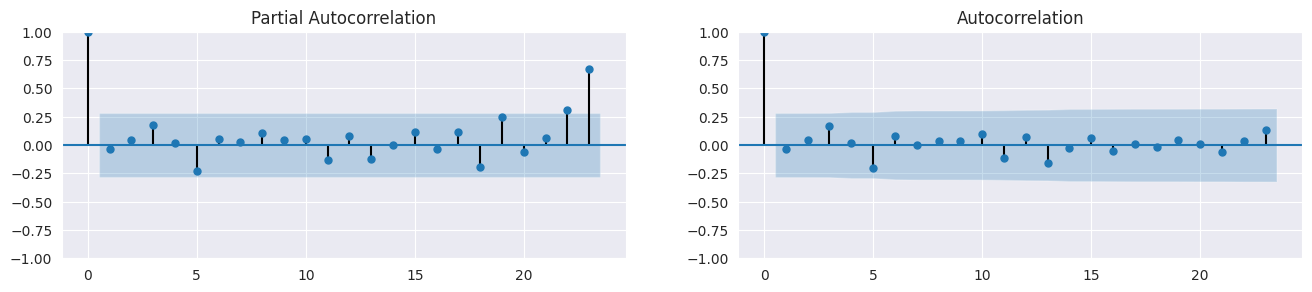

In [52]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_furniture,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_furniture, lags=23,ax=axes[1])
plt.show()

####**Office Supplies Data**

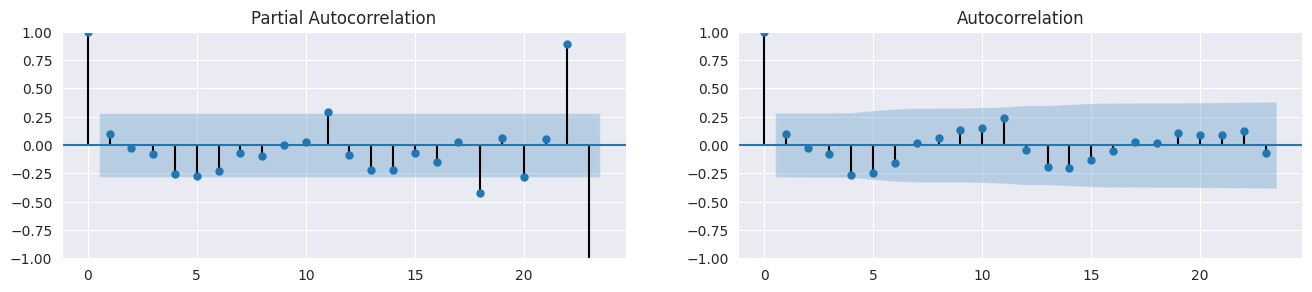

In [53]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_office,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_office, lags=23,ax=axes[1])
plt.show()

####**Technology Data**

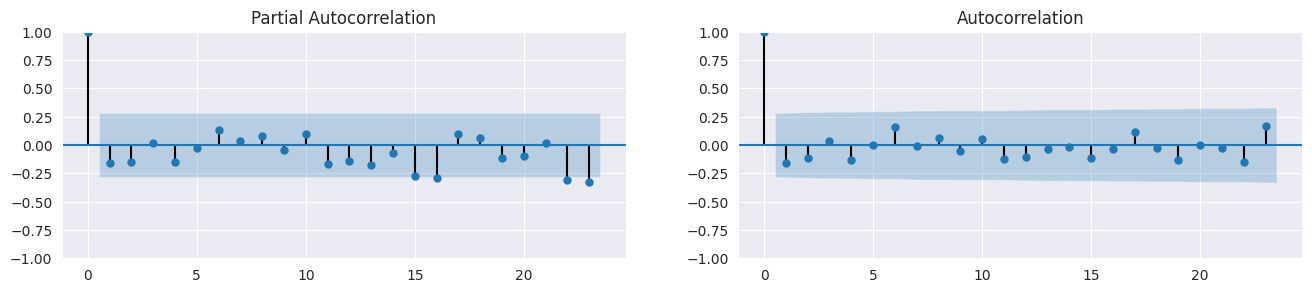

In [54]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_technology,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_technology, lags=23,ax=axes[1])
plt.show()

##Parameters Selection

 - https://www.javatpoint.com/arima-model-in-python#:~:text=ARIMA%2C%20abbreviated%20for%20'Auto%20Regressive,order%20to%20forecast%20future%20values.
 - https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
 - functions and model is referred from the above website.



Parameters of the ARIMA model are defined by 
 - AR(p)-lag order
 - I(d) -degree of difference
 - MA(q) - order of moving average 
    
SARIMAX an extension of ARIMA supports time series data with a seasonal component. it is denoted by order (p,d,q)(P,D,Q)m.
 - P - Seasonal regression
 - D - differencing
 - Q - moving average coefficients
 - m - no.of datapoints in each seasonal cycle

##### The approach for SARIMA model is separated in 2 parts, its pmdarima(originally pyramid-arima, for the anagram of 'py' + 'arima') and sarimax functions.
##### for pmdarima data is divided into test and train data (train data from 2014 to 2015 and remaining data is used as test data (from 2016 to 2017).

## Furniture

In [55]:
#dividing the set into test and train
train_furniture = y_furniture.loc['2014-01-06':'2015-12-30']
test_furniture = y_furniture.loc['2015-12-30':]

### Approach 1: Using pyramid ARIMA (pmdarima) for choosing best parameters


In [56]:
model = pm.auto_arima(train_furniture, start_p=1, start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary().tables[1])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=290.171, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=288.188, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=284.906, Time=0.29 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=286.906, Time=0.67 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=286.906, Time=0.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=282.907, Time=0.15 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=284.907, Time=0.47 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=284.907, Time=0.28

In [57]:
model.fit(train_furniture)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [58]:
model_furniture = SARIMAX(y_furniture,order=(0,1,0),seasonal_order=(1,0,0,12),enforce_invertibility=False)

In [59]:
result_furniture = model_furniture.fit()

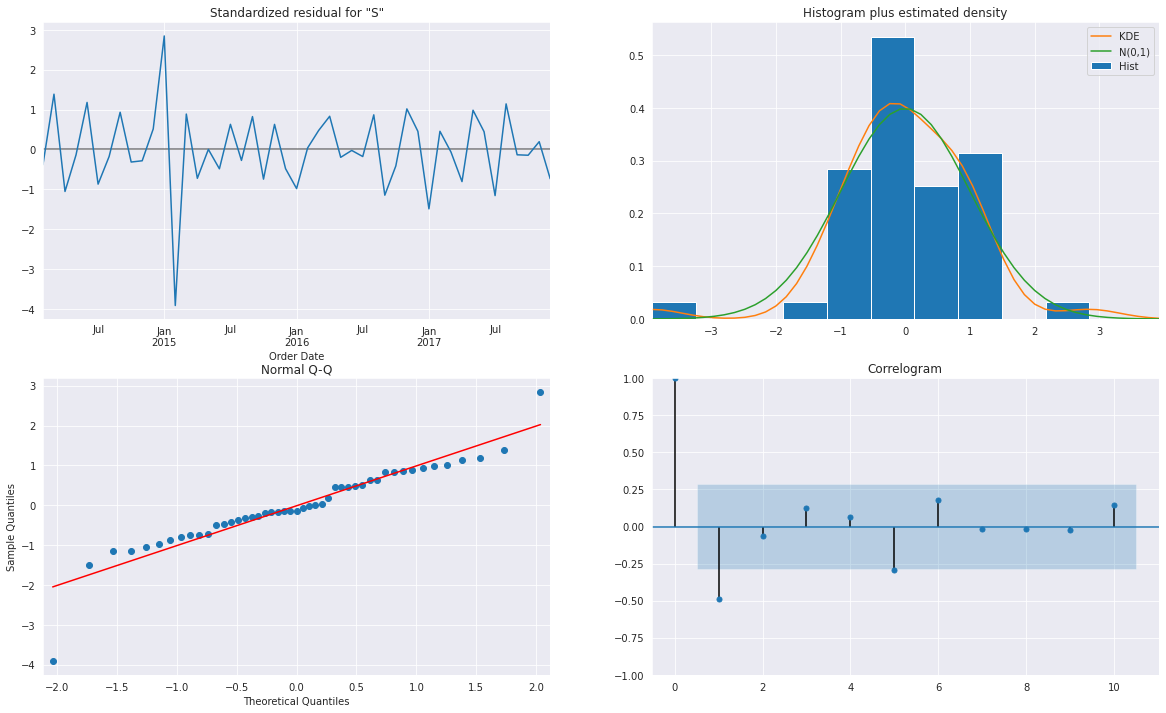

In [60]:
result_furniture.plot_diagnostics(figsize=(20,12))
plt.show()

In [61]:
start = len(train_furniture)
end = len(train_furniture) + len(test_furniture) - 1

In [62]:
prediction_furniture = result_furniture.predict(start,end).rename('SARIMA model')
prediction_furniture

Order Date
2015-12-01    420.304818
2016-01-01    467.722113
2016-02-01    201.969930
2016-03-01    253.494784
2016-04-01    274.772325
2016-05-01    376.051853
2016-06-01    347.036610
2016-07-01    357.075504
2016-08-01    323.285751
2016-09-01    470.142164
2016-10-01    298.325824
2016-11-01    266.792834
2016-12-01    380.679102
2017-01-01    432.520227
2017-02-01    207.885528
2017-03-01    294.756032
2017-04-01    305.620455
2017-05-01    198.534542
2017-06-01    317.729284
2017-07-01    370.141248
2017-08-01    254.864084
2017-09-01    366.332195
2017-10-01    326.182439
2017-11-01    350.341761
Freq: MS, Name: SARIMA model, dtype: float64

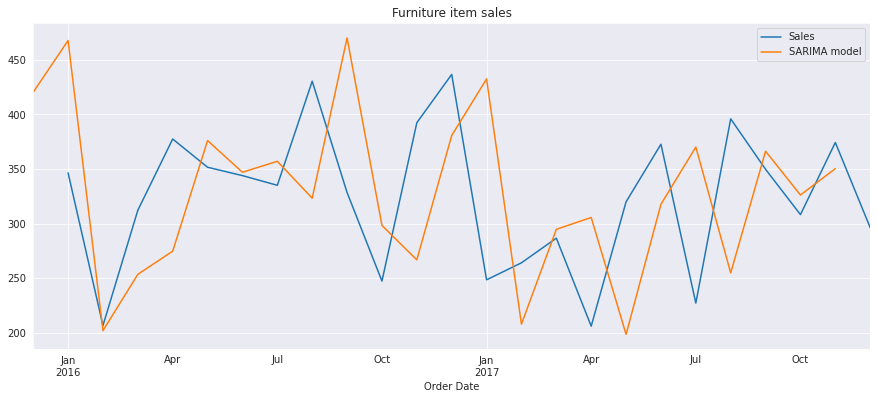

In [63]:
test_furniture.plot(figsize=(15,6),legend=True)
prediction_furniture.plot(legend=True)
plt.title("Furniture item sales")
plt.show()

Its a closer prediction by using SARIMA

####Model evaluation (furniture)

In [64]:
print('Mean Squared Error: ',
      round(mean_squared_error(test_furniture,prediction_furniture),4))
print('Root Mean Squared Error: ',
      round(rmse(test_furniture,prediction_furniture),4))
print('Average: ',
      round(test_furniture.mean(),4))

Mean Squared Error:  13247.0908
Root Mean Squared Error:  115.096
Average:  323.2692


In [65]:
model_furniture_x = SARIMAX(y_furniture,order=(0,1, 0),seasonal_order=(1, 0, 0, 12),enforce_invertibility=False)


In [66]:
result_furniture_final = model_furniture_x.fit()

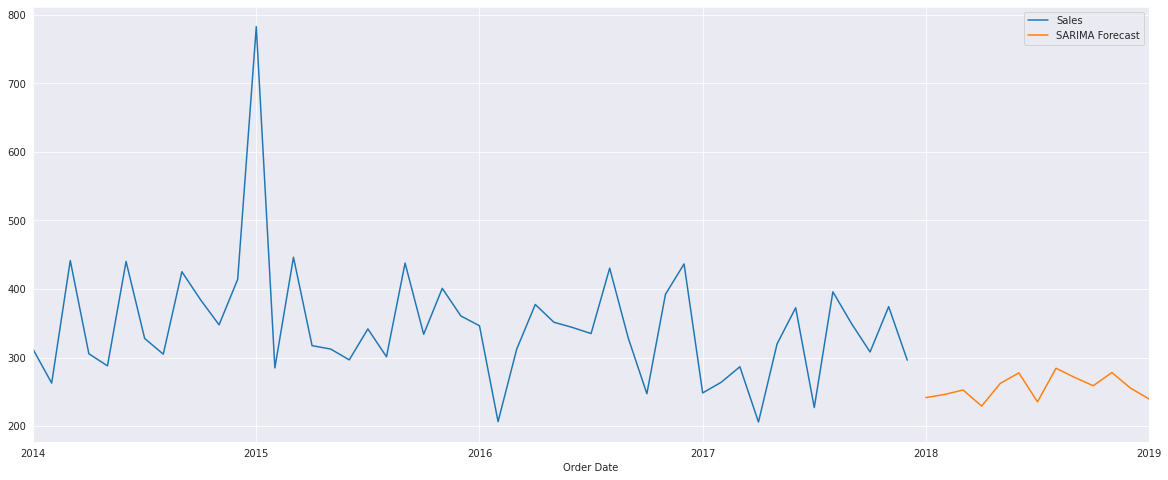

In [67]:
#forecasting for the next year(12 months)
forecast_furniture = result_furniture_final.predict(len(y_furniture),len(y_furniture)+12,typ='levels').rename('SARIMA Forecast')
y_furniture.plot(legend=True,figsize=(20,8))
forecast_furniture.plot(legend=True)
plt.show()

Its a slightly declined trend of furniture sales forecast

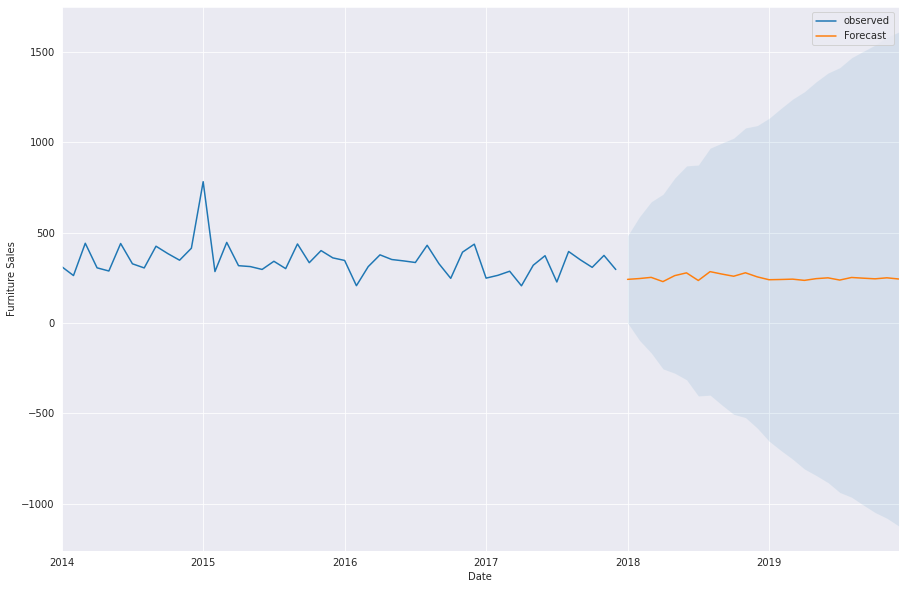

In [68]:
pred_furniture = result_furniture_final.get_forecast(steps=24)
pred_ci_furniture = pred_furniture.conf_int()
ax = y_furniture.plot(label='observed',figsize=(15,10))
pred_furniture.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furniture.index,
               pred_ci_furniture.iloc[:,0],
               pred_ci_furniture.iloc[:,1],alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

#####Its a decreased than previous sales of furnitures for the next 24 months as per the forecast

#### Approach 2: Choosing best parameters with lowest AIC score



 - https://machinelearningmastery.com/probabilistic-model-selection-measures/

In [69]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')
parameters=[]
for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        aic = results.aic
        parameters.append([param,param_seasonal,aic])

result_table = pd.DataFrame(parameters)
result_table.columns = ['parameters',     'parameters_seasonal','aic']
result_table = result_table.sort_values(by='aic',ascending = True).reset_index(drop = True)
minimum = result_table['aic'].min()
a = result_table.loc[result_table['aic'] == minimum]
print(' The best combination that gives the lowest AIC is:')
print(a)

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1304.7159073148189
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.2046489859171
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:272.09198476282904
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1615.3383057725832
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:274.09198456327925
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680666297
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2662.3322445706117
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.54964533646034
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:262.5230517047709
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.14426561458043
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2481.5935659846905
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.4464066250189
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:264.52300131281464
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.638926970597
ARIMA(0, 1, 0

AIC estimates relative quality of model and desired result is to find lowest possible AIC score.
The (p,d,q)(P,D,Q,m) order (0, 1, 1)(0, 1, 1, 12) have lower AIC value of 251.24.

In [70]:
#fitting the model
best_model = SARIMAX(y_furniture, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9982     13.522     -0.074      0.941     -27.502      25.505
ma.S.L12      -0.9855     13.786     -0.071      0.943     -28.005      26.034
sigma2      7620.1353   1.68e+05      0.045      0.964   -3.22e+05    3.37e+05


### Model diagnosis

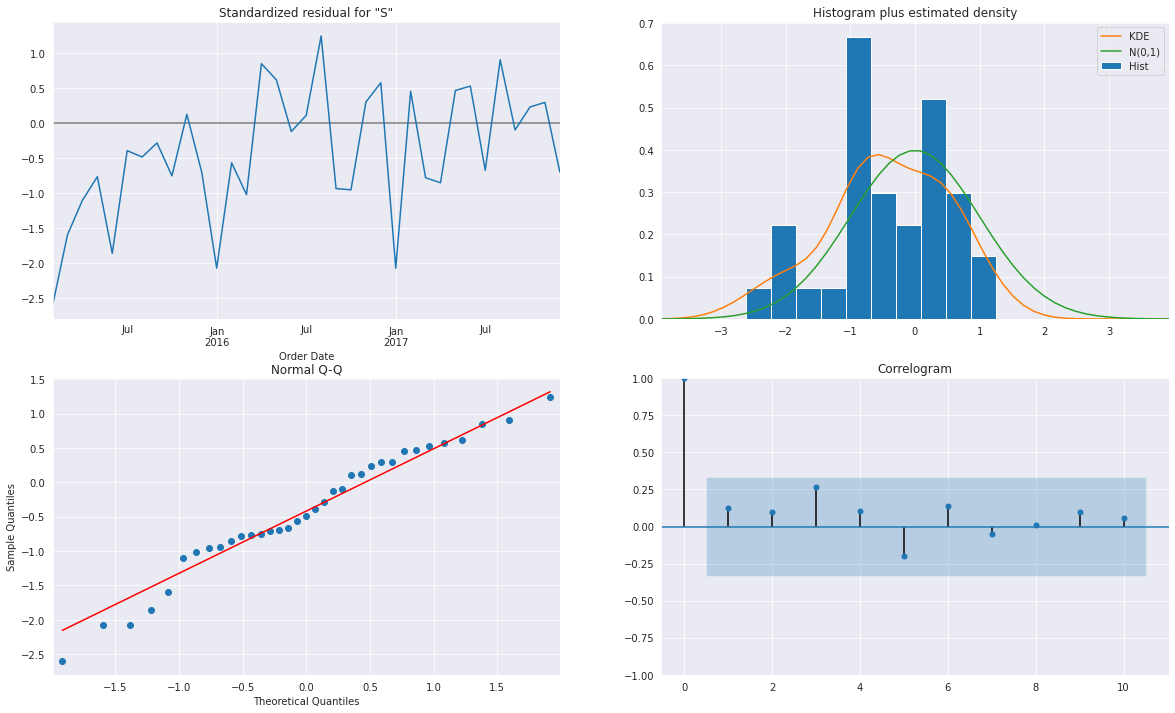

In [71]:
best_model.plot_diagnostics(figsize=(20, 12))
plt.show()

#####Remarks:
It is evident that the data is normally distributed and is not correlated

###Visualizing Forecasts

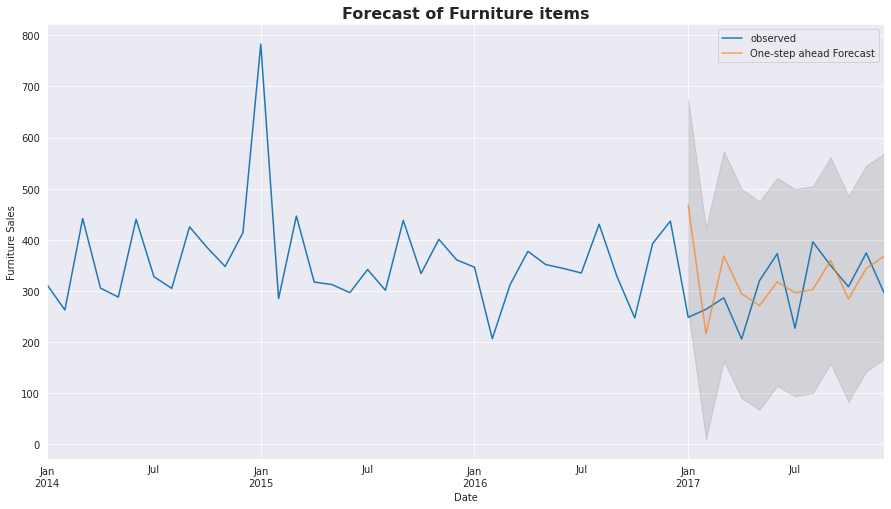

In [72]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15,8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('Forecast of Furniture items', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [73]:
y_forecasted = pred.predicted_mean
y_truth = y_furniture['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))

The Mean Squared Error of our forecasts is 7554.8217

The Root Mean Squared Error of our forecasts is 86.9185


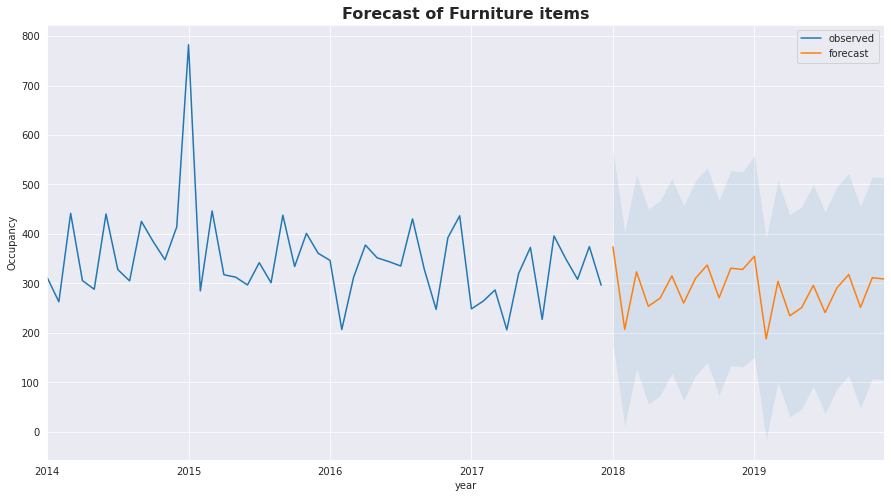

In [74]:
# Lets get the forecast for 2 years i.e., 24 months
pred = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = y_furniture.plot(label='observed', figsize=(15, 8))

pred.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=0.1)
plt.title('Forecast of Furniture items', fontsize=16, fontweight='bold')
ax.set_xlabel('year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

In this too, there is a slight decrease in demand for next 24 months

## Office Supplies

In [75]:
train_office = y_office.loc['2014-01-06':'2015-12-30']
test_office = y_office.loc['2015-12-30':]


### Approach 1: Using pyramid ARIMA (pmdarima) for choosing best parameters




In [76]:
model = pm.auto_arima(train_office, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary().tables[1])

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=250.166, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=243.270, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=241.314, Time=0.03 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=243.269, Time=0.08 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=245.269, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=233.576, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=234.977, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=234.686, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=231.531, Time=0.12 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=inf, Time=

In [77]:
model_office = SARIMAX(y_office,order=(2,2,1),seasonal_order=(0,0,0,12),enforce_invertibility=False)

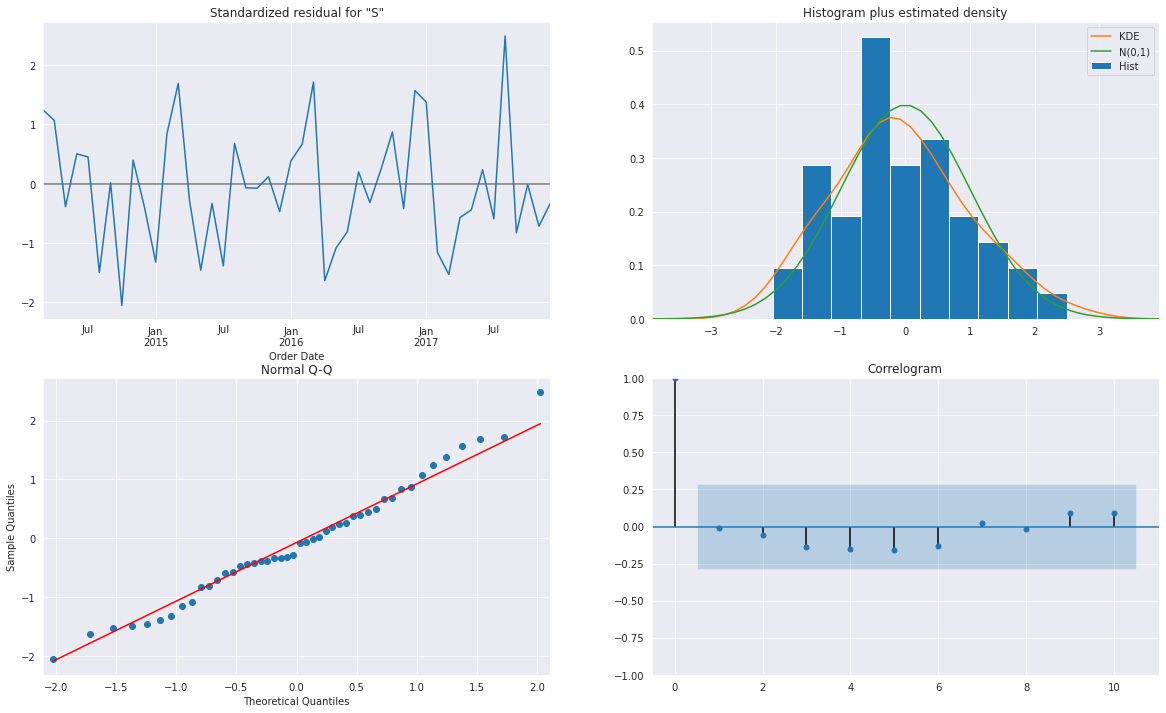

In [78]:
result_office = model_office.fit()
result_office.plot_diagnostics(figsize=(20,12))
plt.show()

Residual plot shows residuals are close to normal distribution and also with Q-Q plot indicates the same. from correlogram, residuals are uncorrelated.

In [79]:
start = len(train_office)
end = len(train_office) + len(test_office) - 1

In [80]:
prediction_office = result_office.predict(start,end).rename('SARIMA model')
prediction_office

Order Date
2015-12-01    109.365852
2016-01-01     99.787364
2016-02-01    110.391604
2016-03-01    124.264918
2016-04-01    170.066843
2016-05-01    143.336956
2016-06-01    124.661338
2016-07-01     91.713589
2016-08-01     96.075383
2016-09-01     89.503017
2016-10-01     96.380431
2016-11-01    114.179061
2016-12-01    110.767233
2017-01-01    148.983762
2017-02-01    179.110001
2017-03-01    170.882876
2017-04-01    139.543074
2017-05-01    114.351567
2017-06-01    102.602023
2017-07-01    109.132642
2017-08-01     95.255049
2017-09-01    150.404655
2017-10-01    136.091573
2017-11-01    150.732988
Freq: MS, Name: SARIMA model, dtype: float64

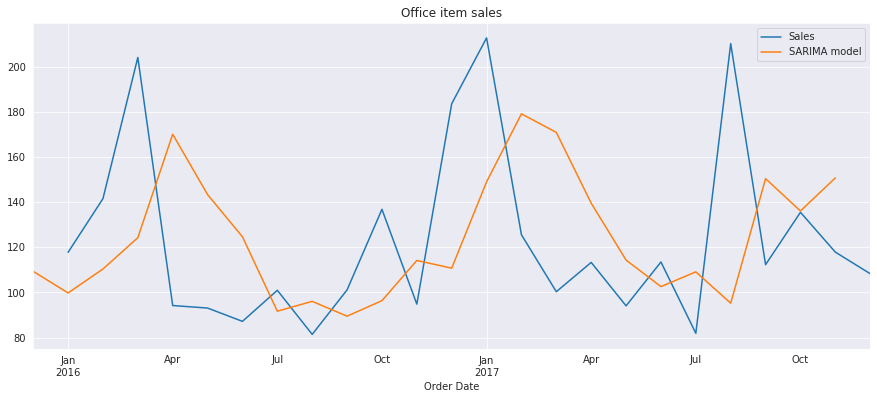

In [81]:
test_office.plot(figsize=(15,6),legend=True)
prediction_office.plot(legend=True)
plt.title("Office item sales");

In [82]:
print('Mean Squared Error: ',
      round(mean_squared_error(test_office,prediction_office),4))
print('Root Mean Squared Error: ',
      round(rmse(test_office,prediction_office),4))
print('Average: ',
      round(test_furniture.mean(),4))

Mean Squared Error:  2672.2301
Root Mean Squared Error:  51.6936
Average:  323.2692


In [83]:
model_office_final = SARIMAX(y_office,order=(2, 2, 1),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_office_final = model_office_final.fit()

In [84]:
forecast_office = result_office_final.predict(len(y_office),len(y_office)+11,typ='levels').rename('SARIMA forecast')

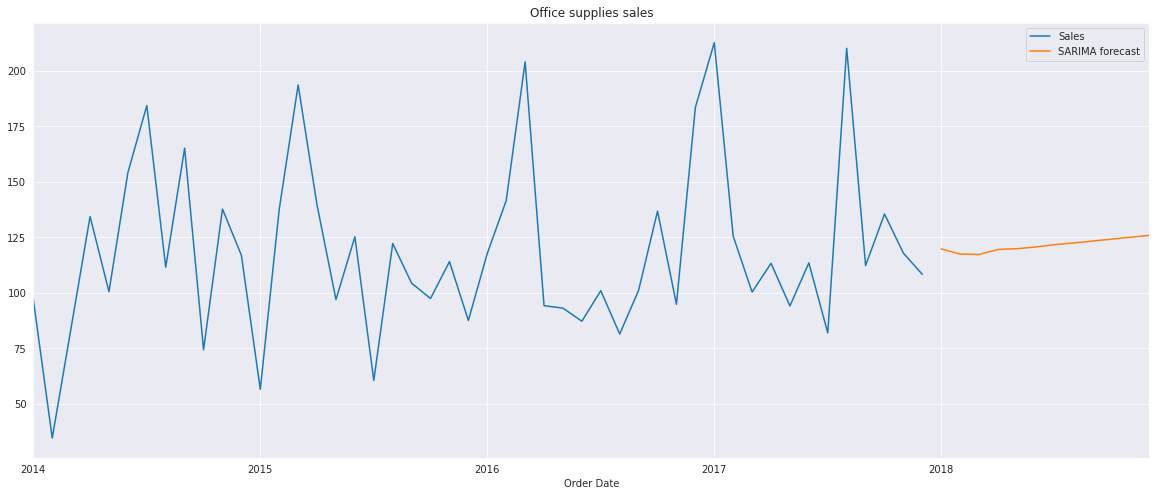

In [85]:
y_office.plot(legend=True,figsize=(20,8))
forecast_office.plot(legend=True)
plt.title("Office supplies sales");

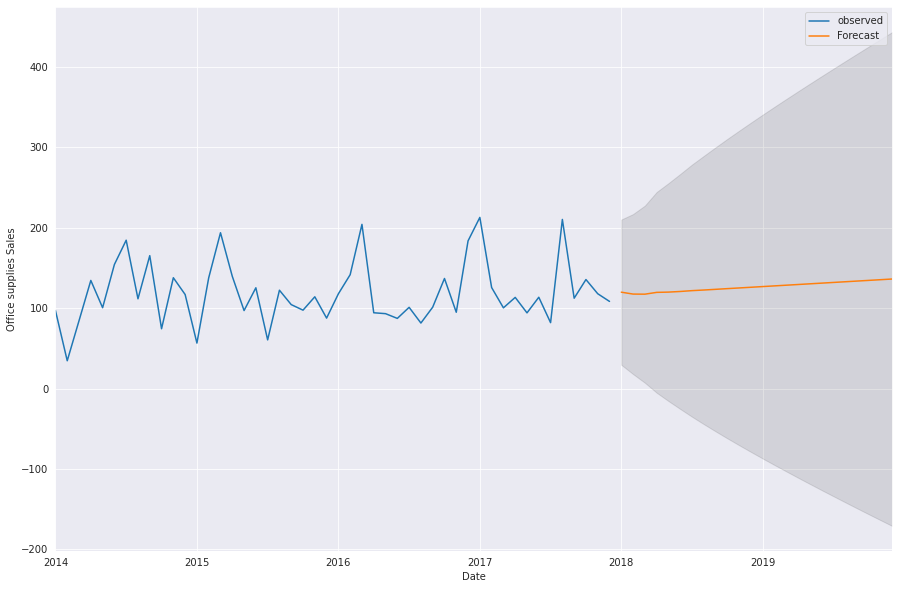

In [86]:
pred_office = result_office_final.get_forecast(steps=24)
pred_ci_office = pred_office.conf_int()
ax = y_office.plot(label='observed',figsize=(15,10))
pred_office.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_office.index,
               pred_ci_office.iloc[:,0],
               pred_ci_office.iloc[:,1],color='k',alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Office supplies Sales')
plt.legend()
plt.show()

#### Approach 2: Choosing best parameters with lowest AIC score

In [87]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages
parameters = []
for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_office,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        aic = results.aic
        parameters.append([param,param_seasonal,aic])

result_table = pd.DataFrame(parameters)
result_table.columns = ['parameters',     'parameters_seasonal','aic']
result_table = result_table.sort_values(by='aic',ascending = True).reset_index(drop = True)
minimum = result_table['aic'].min()
a = result_table.loc[result_table['aic'] == minimum]
print(' The best combination that gives the lowest AIC is:')
print(a)

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:589.5002315061224
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1467.6501171943485
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:383.4175511140716
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.89284131159903
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:394.83867919808836
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1487.5640210349263
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:260.5044719309093
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:250.10262158197176
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:545.8315751699361
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2619.986016388373
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:371.8194830276627
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:240.3985698865137
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:396.43734243158235
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2602.5212044422383
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:262.1735163819379
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:242.26144570274394
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:496.8049609774628
ARIMA(0, 1, 

ARIMA(p,d,q)(P,D,Q)m with order (0,1,1) and seasonal order (0,1,1,12) have lowest AIC score.

In [88]:
#fitting model
best_model = SARIMAX(y_office, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9991     23.237     -0.043      0.966     -46.543      44.545
ma.S.L12      -0.5111      0.541     -0.945      0.345      -1.571       0.549
sigma2      2636.2995   6.02e+04      0.044      0.965   -1.15e+05    1.21e+05


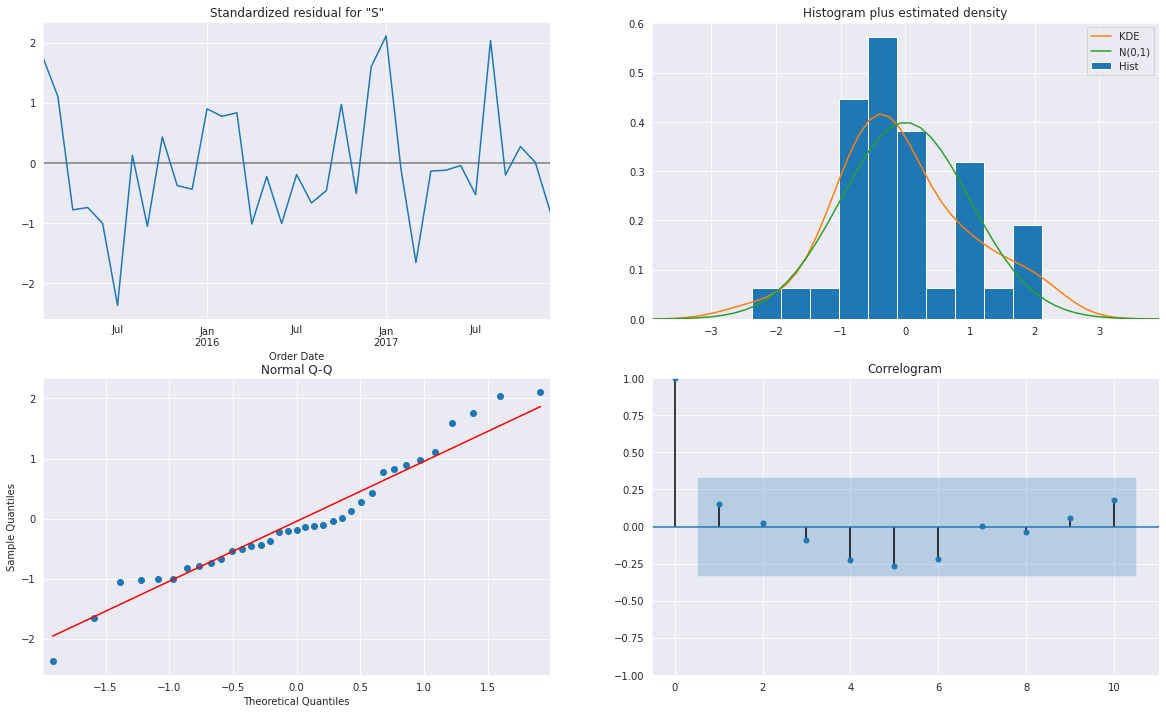

In [89]:
best_model.plot_diagnostics(figsize=(20, 12))
plt.show()

Here residuals are near normal distribution from top right and bottom left plot the correlation plot shows uncorrelated.

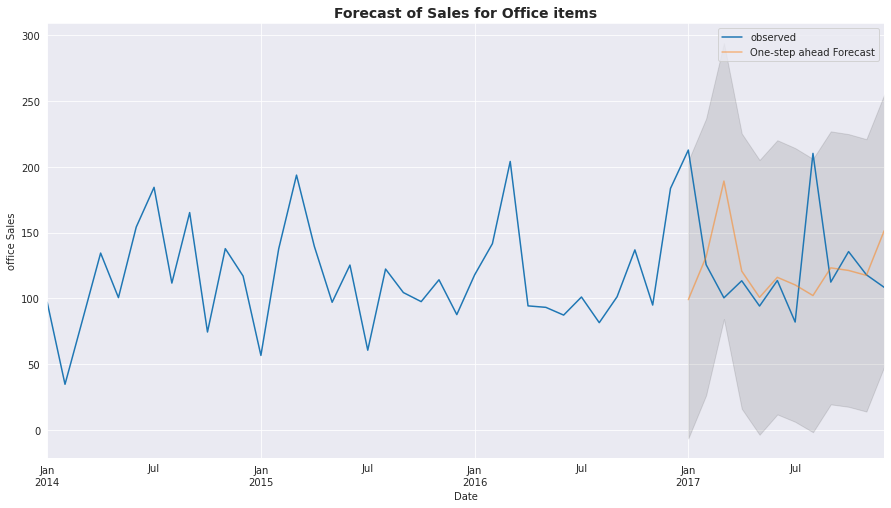

In [90]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_office['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(15, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('Forecast of Sales for Office items', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('office Sales')
plt.legend()

plt.show()

In [91]:
y_forecasted = pred.predicted_mean
y_truth = y_office['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))

The Mean Squared Error of our forecasts is 2969.7685
The Root Mean Squared Error of our forecasts is 54.4956


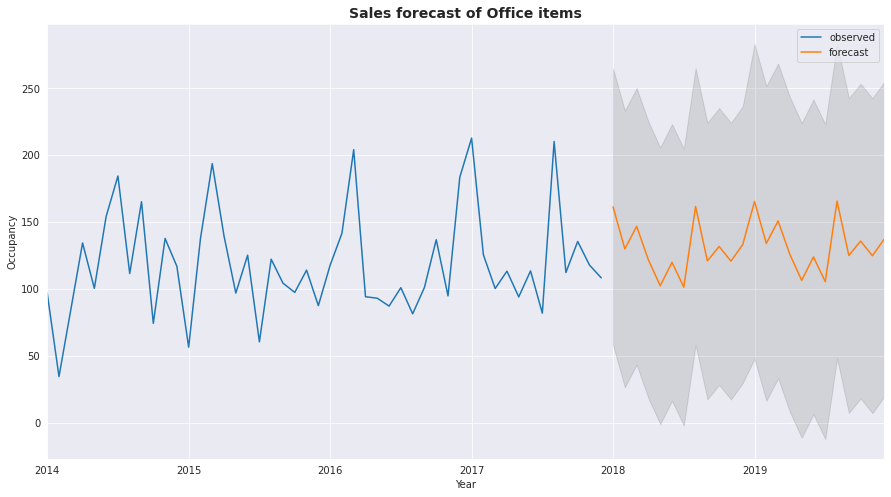

In [92]:
# Get forecast 24 steps ahead in future
pred_uc = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_office.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('Sales forecast of Office items', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()


Forecast and confidence intervals shows demand of office items increasing over years.

## Technology

In [93]:
train_technology = y_technology.loc['2014-01-06':'2015-12-30']
test_technology = y_technology.loc['2015-12-30':]

### Approach 1: Using pyramid ARIMA (pmdarima) for choosing best parameters

In [94]:
model = pm.auto_arima(train_technology, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, 
                      m=12,             
                      d=None,          
                      seasonal=True,  
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary().tables[1])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=322.632, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=325.122, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=353.303, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=324.629, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=324.608, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=326.608, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=323.238, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=323.033, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=325.209, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.848 seconds
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int

In [95]:
model_technology = SARIMAX(y_technology,order=(0,0,0),seasonal_order=(0,0,0,12),enforce_invertibility=False)

####above indicate our data is white noise, we cannot predict with white noise data.

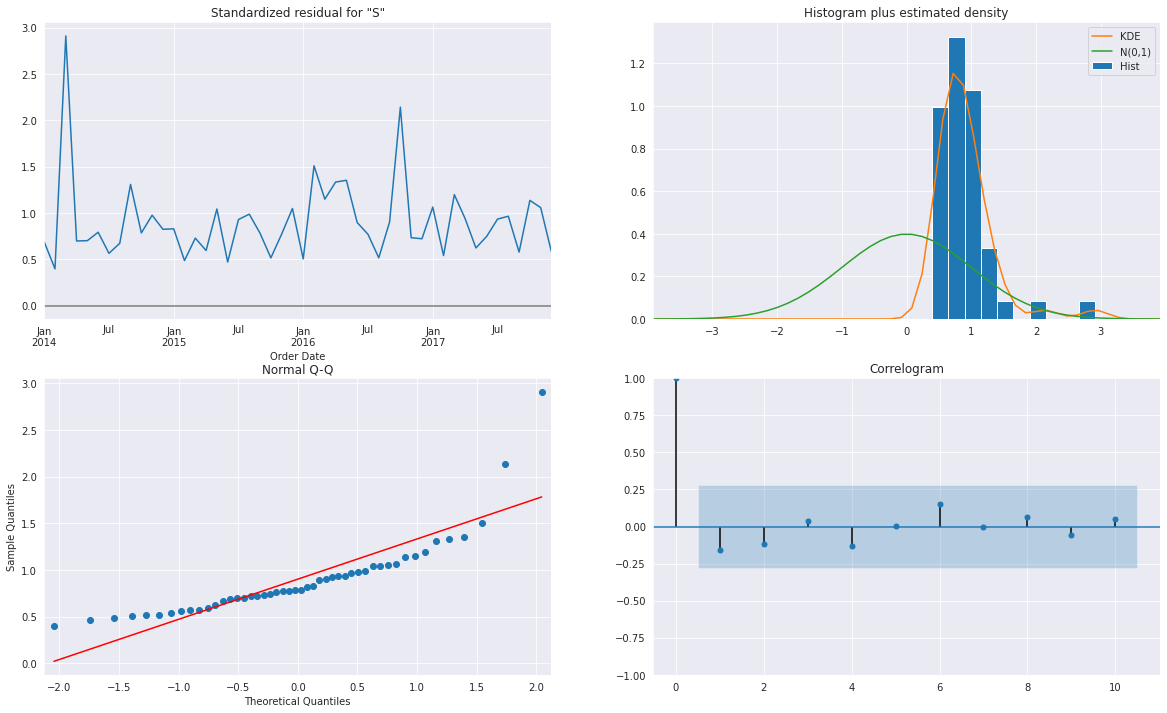

In [96]:
result_technology = model_technology.fit()
result_technology.plot_diagnostics(figsize=(20,12))
plt.show()

It is clear that there are white noise in data so Lets try the second approach.

#### Approach 2: Choosing best parameters with lowest AIC score

In [97]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')
parameters =[]
for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_technology,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        aic = results.aic
        parameters.append([param,param_seasonal,aic])

result_table = pd.DataFrame(parameters)
result_table.columns = ['parameters',     'parameters_seasonal','aic']
result_table = result_table.sort_values(by='aic',ascending = True).reset_index(drop = True)
minimum = result_table['aic'].min()
a = result_table.loc[result_table['aic'] == minimum]
print(' The best combination that gives the lowest AIC is:')
print(a)

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:721.5688506163442
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1441.8331649101506
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:506.0787430128274
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:322.9875452532869
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:514.1576203103062
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1293.7182483012698
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:337.72306528701387
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:324.32656550195793
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:683.3203705205594
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2638.2425953400366
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:494.6399962665531
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:305.7104828501603
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:514.2823881454726
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2579.244011266369
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:336.08723533603563
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:306.6135534235107
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:668.3045721205369
ARIMA(0, 1, 0)

ARIMA(p,d,q)(P,D,Q)m with order (1,1,1) and seasonal order (1,1,1,12) have lowest AIC score.

In [98]:
#fitting model
best_model = SARIMAX(y_technology, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2597      0.252     -1.029      0.303      -0.754       0.235
ma.L1         -0.9989     21.700     -0.046      0.963     -43.531      41.533
ar.S.L12      -0.3489      0.329     -1.062      0.288      -0.993       0.295
ma.S.L12      -0.6468      0.793     -0.816      0.415      -2.201       0.907
sigma2      5.386e+04   1.16e+06      0.046      0.963   -2.22e+06    2.33e+06


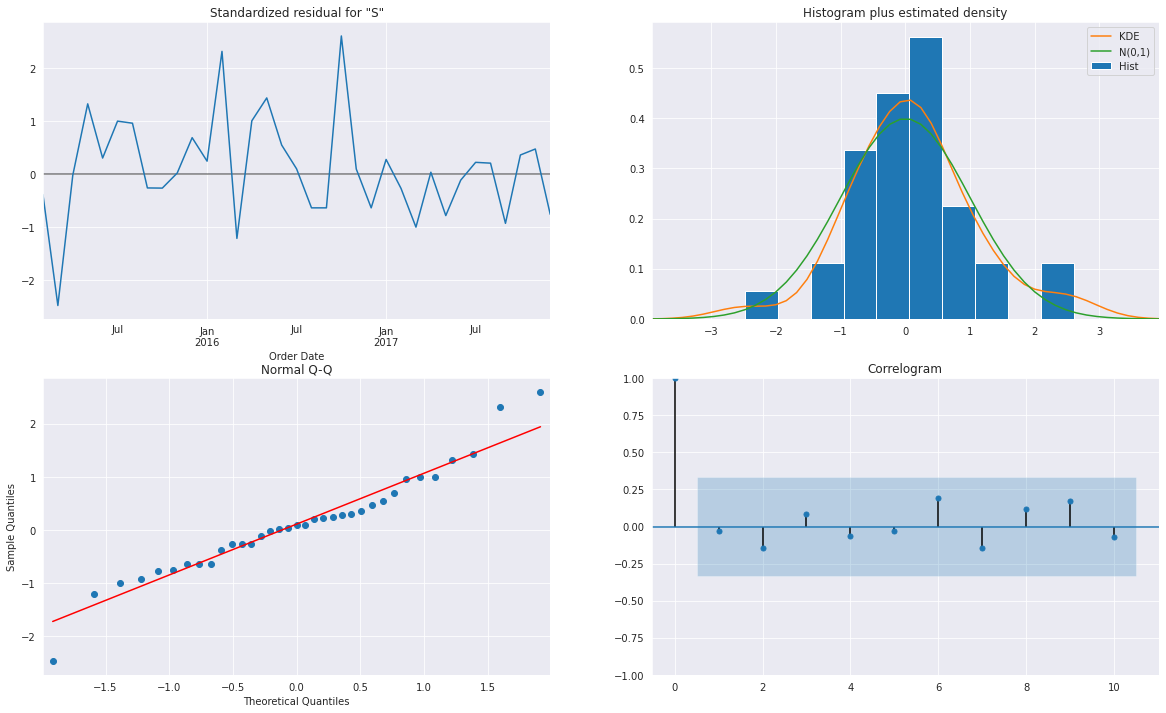

In [99]:
best_model.plot_diagnostics(figsize=(20, 12))
plt.show()

Residuals are normally distributed with zero mean and they are uncorrelated from correlogram. the model is good.

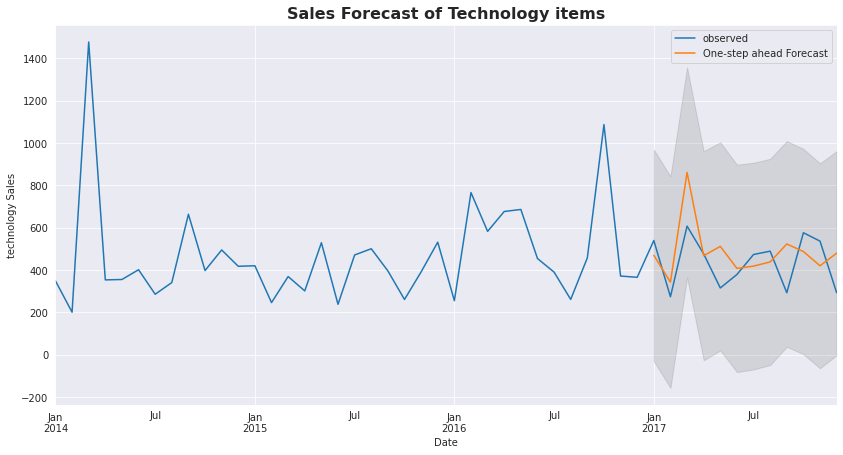

In [100]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_technology['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=1, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('Sales Forecast of Technology items', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('technology Sales')
plt.legend()

plt.show()

In [101]:
y_forecasted = pred.predicted_mean
y_truth = y_technology['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))

The Mean Squared Error of our forecasts is 19070.01
The Root Mean Squared Error of our forecasts is 138.0942


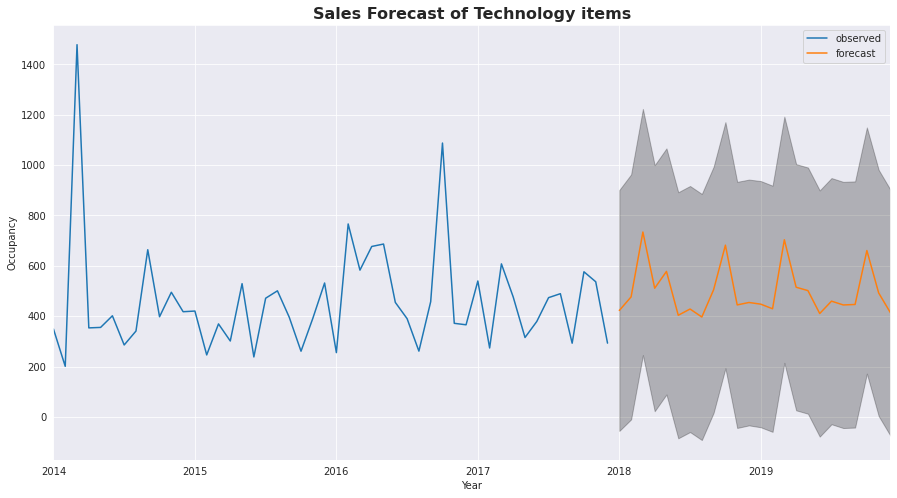

In [102]:
# Get forecast 24 steps ahead in future
pred_uc = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_technology.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Sales Forecast of Technology items', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Somewhat constant trend in sales for technology items is observed.

###**Comparing categories**

In [103]:
furniture_df.shape,office_supplies_data.shape,technology_df.shape

((2121, 1), (6026, 1), (1847, 1))

In [104]:
#furniture_df.drop('Category', axis=1, inplace=True)
#office_supplies_data.drop('Category', axis=1, inplace=True)
#technology_df('Category', axis=1, inplace=True)

In [105]:
furniture_df = furniture_df.sort_values('Order Date')
office_supplies_data = office_supplies_data.sort_values('Order Date')
technology_df = technology_df.sort_values('Order Date')

furniture_df = furniture_df.groupby('Order Date')['Sales'].sum().reset_index()
office_supplies_data= office_supplies_data.groupby('Order Date')['Sales'].sum().reset_index()
technology_df = technology_df.groupby('Order Date')['Sales'].sum().reset_index()

furniture_df = furniture_df.set_index('Order Date')
office_supplies_data = office_supplies_data.set_index('Order Date')
technology_df = technology_df.set_index('Order Date')

y_furniture = furniture_df['Sales'].resample('MS').mean()
y_office = office_supplies_data['Sales'].resample('MS').mean()
y_technology = technology_df['Sales'].resample('MS').mean()

In [106]:
furniture = pd.DataFrame({'Order Date': y_furniture.index , 'Sales':y_furniture.values})
furniture.head()

Order Date       Sales
0 2014-01-01  480.194231
1 2014-02-01  367.931600
2 2014-03-01  857.291529
3 2014-04-01  567.488357
4 2014-05-01  432.049188

In [107]:
office = pd.DataFrame({'Order Date': y_office.index , 'Sales':y_office.values})
office.head()

Order Date       Sales
0 2014-01-01  285.357647
1 2014-02-01   63.042588
2 2014-03-01  391.176318
3 2014-04-01  464.794750
4 2014-05-01  324.346545

In [108]:
technology = pd.DataFrame({'Order Date': y_technology.index , 'Sales':y_technology.values})
technology.head()

Order Date        Sales
0 2014-01-01   449.041429
1 2014-02-01   229.787143
2 2014-03-01  2031.948375
3 2014-04-01   613.028933
4 2014-05-01   564.698588

In [109]:
store = pd.merge(furniture,office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales', 'Sales_z': 'technology_sales'}, inplace=True)
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

In [110]:
store_office_furniture_technology = technology.merge(store, how='inner', on='Order Date')
store_office_furniture_technology.rename(columns={'Sales': 'technology_sales', 'Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)
store_office_furniture_technology

Order Date  technology_sales  furniture_sales  office_sales
0  2014-01-01        449.041429       480.194231    285.357647
1  2014-02-01        229.787143       367.931600     63.042588
2  2014-03-01       2031.948375       857.291529    391.176318
3  2014-04-01        613.028933       567.488357    464.794750
4  2014-05-01        564.698588       432.049188    324.346545
5  2014-06-01        766.905909       695.059242    588.774409
6  2014-07-01        533.608933       601.169500    756.060400
7  2014-08-01        708.435385       457.521656    541.879143
8  2014-09-01       2035.838133       992.353367   1015.677704
9  2014-10-01        596.900900       769.015437    267.078815
10 2014-11-01       1208.056320       980.221486    959.372714
11 2014-12-01       1160.732889      1532.298325    692.556231
12 2015-01-01        925.070800       978.328467    129.198571
13 2015-02-01        431.121250       522.395667    335.504188
14 2015-03-01        574.662333       781.236437    690.545522
15 2015-04-01        697.559500       805.822962    502.342320
16 2015-05-01        831.642857       624.996700    364.549440
17 2015-06-01        429.024400       428.565500    560.407737
18 2015-07-01        691.397733       719.706316    205.214739
19 2015-08-01       1108.902286       602.412012    558.814667
20 2015-09-01        950.856400      1382.790684    772.230680
21 2015-10-01        594.716111       632.980184    361.392083
22 2015-11-01       1037.982652      1286.701354    757.790357
23 2015-12-01       1619.637636      1049.355418    540.055800
24 2016-01-01        374.671067       508.182867    331.230125
25 2016-02-01       1225.891400       356.868273    357.597368
26 2016-03-01       1135.150105       609.575810    693.877240
27 2016-04-01        875.911882       695.373158    462.932478
28 2016-05-01       1601.816167       687.265227    449.489724
29 2016-06-01       1023.259500       816.910750    436.072400
30 2016-07-01        829.312500       768.736412    587.474727
31 2016-08-01        483.620100       734.307782    344.605385
32 2016-09-01       1144.170300      1135.953371    830.847786
33 2016-10-01       1970.835875       624.872474    678.408083
34 2016-11-01       1085.642360      1271.345152    787.972231
35 2016-12-01        970.554870      1410.719808   1357.055929
36 2017-01-01       1195.218071       397.602133    967.013136
37 2017-02-01        430.501714       528.179800    389.882737
38 2017-03-01       1392.859250       544.672240    538.899481
39 2017-04-01        825.559133       453.297905    558.229296
40 2017-05-01        678.329400       678.302328    508.776444
41 2017-06-01        853.055000       826.460291    650.463038
42 2017-07-01       1054.996636       562.524857    393.902615
43 2017-08-01        978.842333       857.881889   1156.148154
44 2017-09-01       1077.704120      1209.508583   1139.137250
45 2017-10-01       1493.439227       875.362728    886.045846
46 2017-11-01       1996.750920      1277.817759   1124.012036
47 2017-12-01        955.865652      1256.298672   1049.549724

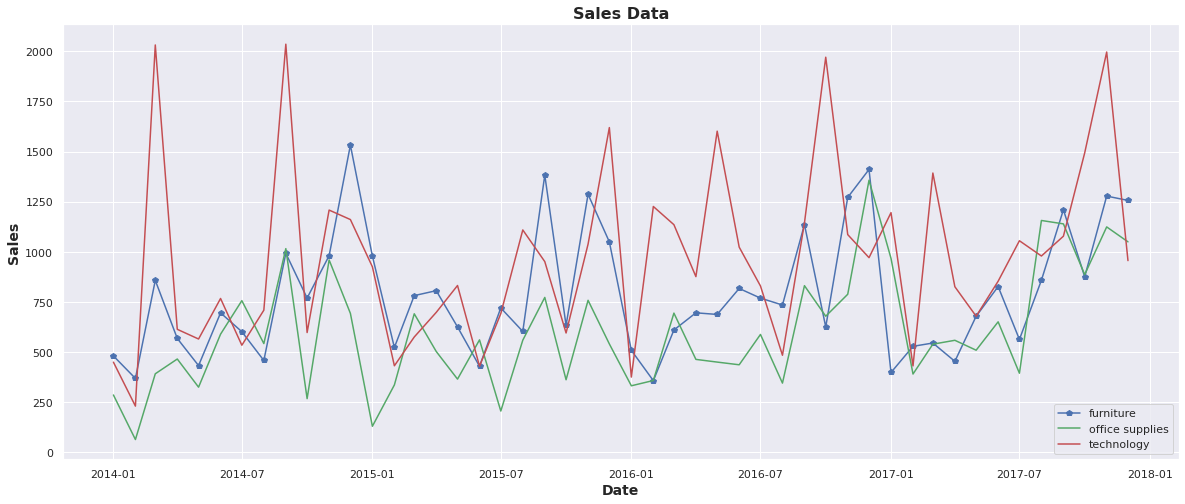

In [111]:
sns.set(font_scale=1)
plt.figure(figsize=(20,8))
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['furniture_sales'],'p-',label='furniture')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['office_sales'],'g-',label='office supplies')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales Data', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

##Findings:
 - from above plot, it is clear that technology items are most selling item with staggering peak points compared to other categories and sales of office supplies is least.

 - sales of technology items is more than 2000 in the year 2014 but after that sales is declining in 2015 until mid 2016.

 - Sales of furniture items shows a maximum at the end of year 2014 and a similiar rise occurs in second half of 2015 and 2016.

 - Office supplies has maximum sales at the end of 2016.

###**Comparing sales of different categories**

###a) Furniture vs office items

In [112]:
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

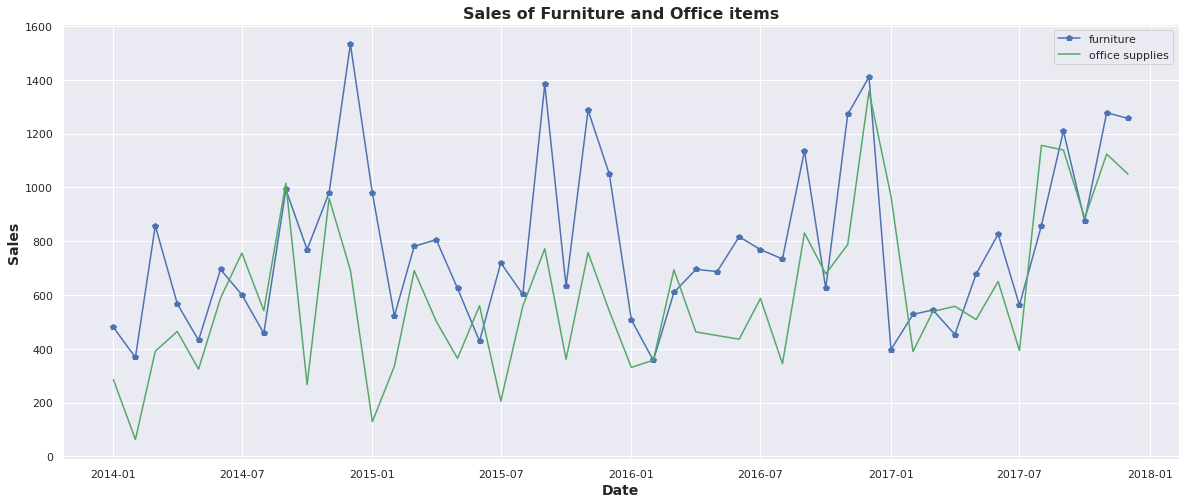

In [113]:
plt.figure(figsize=(20,8))

plt.plot(store['Order Date'],store['furniture_sales'],'p-',label='furniture')
plt.plot(store['Order Date'],store['office_sales'],'g-',label='office supplies')

plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Office items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

 - Sales of both product categories is increasing over years and is nearly similar to each other after mid-2016.

 - Furniture items have high sales during september 2014 and lower sales during march of 2014 and 2016 while Office items have lower sales during march 2014.
 - Sales of both categories are high during second half of year.

###b) Furniture vs Technology items sales

In [114]:
store_furniture_technology = pd.merge(furniture,technology, how='inner', on='Order Date')
store_furniture_technology.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_furniture_technology.head()

Order Date  furniture_sales  technology_sales
0 2014-01-01       480.194231        449.041429
1 2014-02-01       367.931600        229.787143
2 2014-03-01       857.291529       2031.948375
3 2014-04-01       567.488357        613.028933
4 2014-05-01       432.049188        564.698588

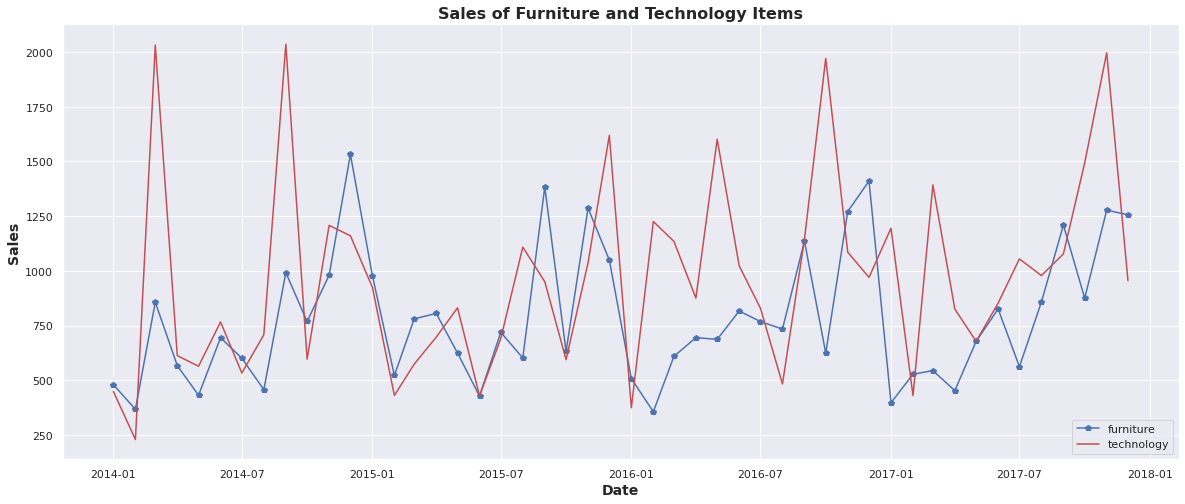

In [115]:
plt.figure(figsize=(20,8))
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['furniture_sales'],'p-',label='furniture')
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

It is evident that technology items demand is more than furniture items by looking at the plot

 - higher sales for technology is observed in 2014, secondly in 4th quarter of 2017.
 - higher sales for furniture was observed at the end of 2014.
 - The demand is lower for both categories at the first quarter of the year, compared to other months of the year sales

###c) office items vs technology sales

In [116]:
store_office_technology = pd.merge(office,technology, how='inner', on='Order Date')
store_office_technology.rename(columns={'Sales_x': 'office_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_office_technology.head()

Order Date  office_sales  technology_sales
0 2014-01-01    285.357647        449.041429
1 2014-02-01     63.042588        229.787143
2 2014-03-01    391.176318       2031.948375
3 2014-04-01    464.794750        613.028933
4 2014-05-01    324.346545        564.698588

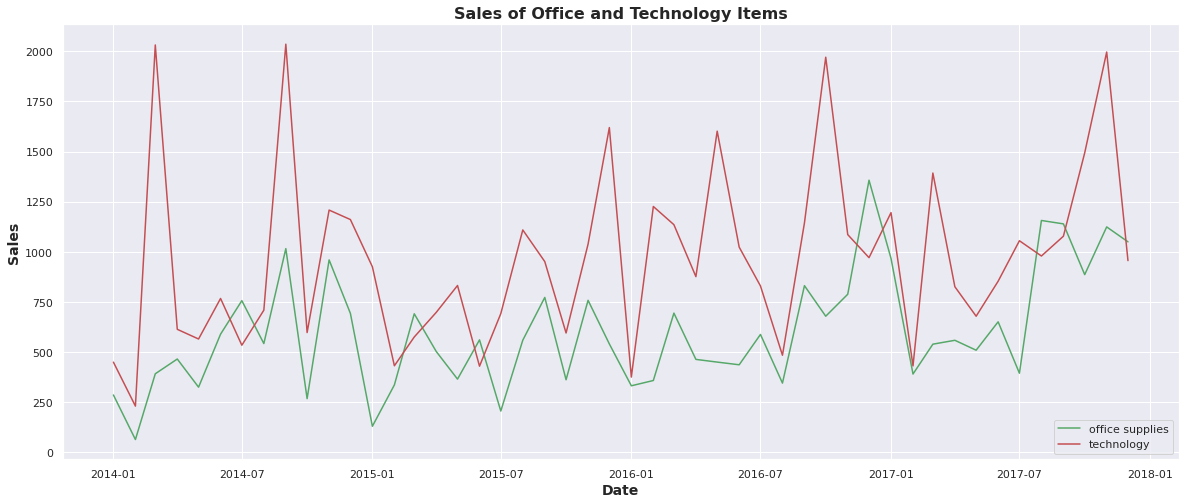

In [117]:
plt.figure(figsize=(20,8))
plt.plot(store_office_technology ['Order Date'],store_office_technology ['office_sales'],'g-',label='office supplies')
plt.plot(store_office_technology ['Order Date'],store_office_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Office and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

Increasing trend is observed for both categories from 2014 to 2018. Here also technology items have higher sales than office supplies which makes it highly demandable product. Higher sales of furniture was observed on september of 2016.

###Findings:
 - Technology items is the highest selling product category.
 - Office items is comparitively less selling category in superstore.

#Forecasting using Fbprophet library

In [118]:
y_furniture_df = y_furniture.to_frame()
y_furniture_df['ds'] = y_furniture_df.index
y_furniture_df.columns = ['y','ds']
y_furniture_df

y         ds
Order Date                        
2014-01-01   480.194231 2014-01-01
2014-02-01   367.931600 2014-02-01
2014-03-01   857.291529 2014-03-01
2014-04-01   567.488357 2014-04-01
2014-05-01   432.049188 2014-05-01
2014-06-01   695.059242 2014-06-01
2014-07-01   601.169500 2014-07-01
2014-08-01   457.521656 2014-08-01
2014-09-01   992.353367 2014-09-01
2014-10-01   769.015437 2014-10-01
2014-11-01   980.221486 2014-11-01
2014-12-01  1532.298325 2014-12-01
2015-01-01   978.328467 2015-01-01
2015-02-01   522.395667 2015-02-01
2015-03-01   781.236437 2015-03-01
2015-04-01   805.822962 2015-04-01
2015-05-01   624.996700 2015-05-01
2015-06-01   428.565500 2015-06-01
2015-07-01   719.706316 2015-07-01
2015-08-01   602.412012 2015-08-01
2015-09-01  1382.790684 2015-09-01
2015-10-01   632.980184 2015-10-01
2015-11-01  1286.701354 2015-11-01
2015-12-01  1049.355418 2015-12-01
2016-01-01   508.182867 2016-01-01
2016-02-01   356.868273 2016-02-01
2016-03-01   609.575810 2016-03-01
2016-04-01   695.373158 2016-04-01
2016-05-01   687.265227 2016-05-01
2016-06-01   816.910750 2016-06-01
2016-07-01   768.736412 2016-07-01
2016-08-01   734.307782 2016-08-01
2016-09-01  1135.953371 2016-09-01
2016-10-01   624.872474 2016-10-01
2016-11-01  1271.345152 2016-11-01
2016-12-01  1410.719808 2016-12-01
2017-01-01   397.602133 2017-01-01
2017-02-01   528.179800 2017-02-01
2017-03-01   544.672240 2017-03-01
2017-04-01   453.297905 2017-04-01
2017-05-01   678.302328 2017-05-01
2017-06-01   826.460291 2017-06-01
2017-07-01   562.524857 2017-07-01
2017-08-01   857.881889 2017-08-01
2017-09-01  1209.508583 2017-09-01
2017-10-01   875.362728 2017-10-01
2017-11-01  1277.817759 2017-11-01
2017-12-01  1256.298672 2017-12-01

In [119]:
#Imported the fbprophet libraary in the first cell

In [147]:
m_furniture = Prophet()

m_furniture.fit(y_furniture_df)

future_furniture = m_furniture.make_future_dataframe(periods=24,freq='MS')

future_furniture

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/w538oozd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/clig6vfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81776', 'data', 'file=/tmp/tmphrhxh9c_/w538oozd.json', 'init=/tmp/tmphrhxh9c_/clig6vfi.json', 'output', 'file=/tmp/tmphrhxh9c_/prophet_modelp9q1ky4s/prophet_model-20221112192258.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
0  2014-01-01
1  2014-02-01
2  2014-03-01
3  2014-04-01
4  2014-05-01
..        ...
67 2019-08-01
68 2019-09-01
69 2019-10-01
70 2019-11-01
71 2019-12-01

[72 rows x 1 columns]

In [148]:
forecast_furniture = m_furniture.predict(future_furniture)
forecast_furniture

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2014-01-01  726.058109   299.605129   761.864443   726.058109   726.058109   
1  2014-02-01  727.494421   225.230009   697.229556   727.494421   727.494421   
2  2014-03-01  728.791734   460.281894   942.415149   728.791734   728.791734   
3  2014-04-01  730.228046   391.675792   875.301247   730.228046   730.228046   
4  2014-05-01  731.618025   328.859215   808.202410   731.618025   731.618025   
..        ...         ...          ...          ...          ...          ...   
67 2019-08-01  820.483987   417.226425   913.233755   820.483946   820.484024   
68 2019-09-01  821.920298  1137.000148  1609.483878   821.920254   821.920338   
69 2019-10-01  823.310277   563.373090  1044.184092   823.310230   823.310320   
70 2019-11-01  824.746588  1006.475255  1462.964582   824.746537   824.746633   
71 2019-12-01  826.136566  1008.131441  1471.420979   826.136511   826.136615   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0      -190.686099           -190.686099           -190.686099 -190.686099   
1      -276.379157           -276.379157           -276.379157 -276.379157   
2       -22.388253            -22.388253            -22.388253  -22.388253   
3      -100.140909           -100.140909           -100.140909 -100.140909   
4      -160.818882           -160.818882           -160.818882 -160.818882   
..             ...                   ...                   ...         ...   
67     -152.741668           -152.741668           -152.741668 -152.741668   
68      551.714450            551.714450            551.714450  551.714450   
69      -13.792342            -13.792342            -13.792342  -13.792342   
70      413.144519            413.144519            413.144519  413.144519   
71      417.366914            417.366914            417.366914  417.366914   

    yearly_lower  yearly_upper  multiplicative_terms  \
0    -190.686099   -190.686099                   0.0   
1    -276.379157   -276.379157                   0.0   
2     -22.388253    -22.388253                   0.0   
3    -100.140909   -100.140909                   0.0   
4    -160.818882   -160.818882                   0.0   
..           ...           ...                   ...   
67   -152.741668   -152.741668                   0.0   
68    551.714450    551.714450                   0.0   
69    -13.792342    -13.792342                   0.0   
70    413.144519    413.144519                   0.0   
71    417.366914    417.366914                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0   535.372010  
1                          0.0                         0.0   451.115264  
2                          0.0                         0.0   706.403481  
3                          0.0                         0.0   630.087137  
4                          0.0                         0.0   570.799142  
..                         ...                         ...          ...  
67                         0.0                         0.0   667.742319  
68                         0.0                         0.0  1373.634748  
69                         0.0                         0.0   809.517935  
70                         0.0                         0.0  1237.891107  
71                         0.0                         0.0  1243.503480  

[72 rows x 16 columns]

In [122]:
forecast_furniture.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [123]:
forecast_furniture[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

ds   yhat_lower   yhat_upper         yhat
60 2019-01-01   530.869348   842.904680   680.605875
61 2019-02-01   305.705320   634.023798   471.017210
62 2019-03-01   696.154097  1024.544561   860.017310
63 2019-04-01   608.647640   931.165545   761.303064
64 2019-05-01   483.907007   782.633254   631.586855
65 2019-06-01   447.929269   763.348220   609.810663
66 2019-07-01   606.969213   939.359229   770.754006
67 2019-08-01   509.722172   829.251737   667.742319
68 2019-09-01  1225.990117  1529.097564  1373.634748
69 2019-10-01   651.621189   954.186095   809.517935
70 2019-11-01  1081.183371  1395.856214  1237.891107
71 2019-12-01  1074.235617  1399.421938  1243.503480

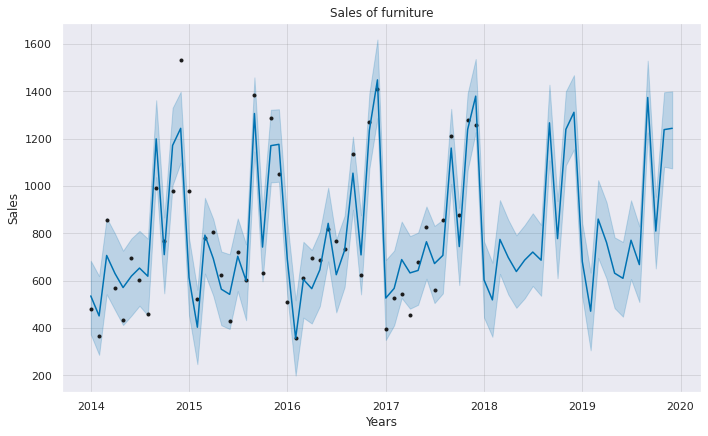

In [124]:
m_furniture.plot(forecast_furniture);
plt.title('Sales of furniture')
plt.xlabel('Years')
plt.ylabel('Sales');

Above plot is forecasting of furniture items sales for the next two years and it shows increasing trend in sales for the upcoming years.

 - High sales is predicted on December of 2018 and August, september in 2019.
 - Its a highly unusual and unreliable forecast model using prophet library


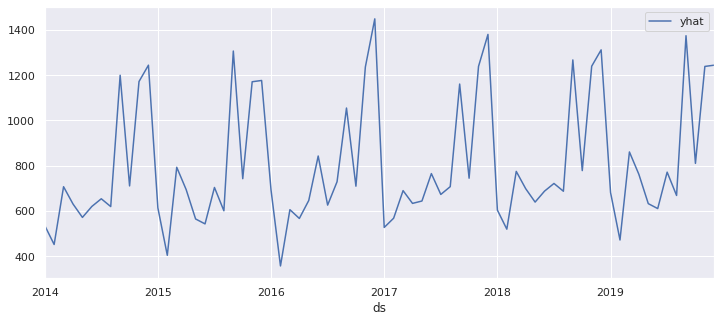

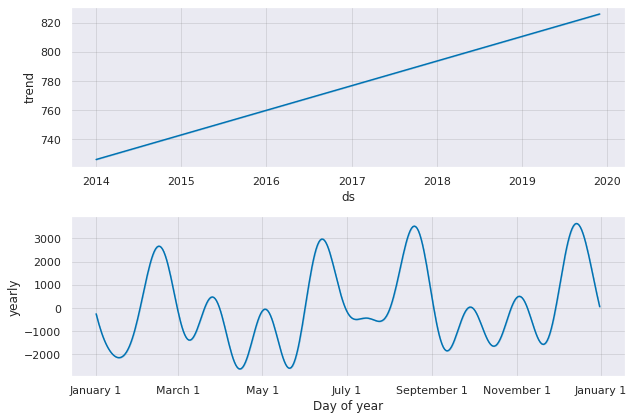

In [125]:
plot_plotly(m_furniture, forecast_furniture)
forecast_furniture.plot(x='ds',y='yhat',figsize=(12,5))

m_furniture.plot_components(forecast_furniture);

###Note:
 - The trend plot shows linearly increasing demand of furniture items from 2014 to 2020.
 - From the yearly seasonality plot, it is clear that high seasonality occur in the month of november and December.
 - low seasonality is seen middle of January and in february.

In [126]:
plot_components_plotly(m_furniture , forecast_furniture)

###Office supplies


In [127]:
y_office_df = y_office.to_frame()
y_office_df['ds'] = y_office_df.index
y_office_df.columns = ['y','ds']
y_office_df

y         ds
Order Date                        
2014-01-01   285.357647 2014-01-01
2014-02-01    63.042588 2014-02-01
2014-03-01   391.176318 2014-03-01
2014-04-01   464.794750 2014-04-01
2014-05-01   324.346545 2014-05-01
2014-06-01   588.774409 2014-06-01
2014-07-01   756.060400 2014-07-01
2014-08-01   541.879143 2014-08-01
2014-09-01  1015.677704 2014-09-01
2014-10-01   267.078815 2014-10-01
2014-11-01   959.372714 2014-11-01
2014-12-01   692.556231 2014-12-01
2015-01-01   129.198571 2015-01-01
2015-02-01   335.504188 2015-02-01
2015-03-01   690.545522 2015-03-01
2015-04-01   502.342320 2015-04-01
2015-05-01   364.549440 2015-05-01
2015-06-01   560.407737 2015-06-01
2015-07-01   205.214739 2015-07-01
2015-08-01   558.814667 2015-08-01
2015-09-01   772.230680 2015-09-01
2015-10-01   361.392083 2015-10-01
2015-11-01   757.790357 2015-11-01
2015-12-01   540.055800 2015-12-01
2016-01-01   331.230125 2016-01-01
2016-02-01   357.597368 2016-02-01
2016-03-01   693.877240 2016-03-01
2016-04-01   462.932478 2016-04-01
2016-05-01   449.489724 2016-05-01
2016-06-01   436.072400 2016-06-01
2016-07-01   587.474727 2016-07-01
2016-08-01   344.605385 2016-08-01
2016-09-01   830.847786 2016-09-01
2016-10-01   678.408083 2016-10-01
2016-11-01   787.972231 2016-11-01
2016-12-01  1357.055929 2016-12-01
2017-01-01   967.013136 2017-01-01
2017-02-01   389.882737 2017-02-01
2017-03-01   538.899481 2017-03-01
2017-04-01   558.229296 2017-04-01
2017-05-01   508.776444 2017-05-01
2017-06-01   650.463038 2017-06-01
2017-07-01   393.902615 2017-07-01
2017-08-01  1156.148154 2017-08-01
2017-09-01  1139.137250 2017-09-01
2017-10-01   886.045846 2017-10-01
2017-11-01  1124.012036 2017-11-01
2017-12-01  1049.549724 2017-12-01

In [128]:
m_office = Prophet()

m_office.fit(y_office_df)

future_office = m_office.make_future_dataframe(periods=24,freq='MS')

future_office

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/st_o3p3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/ke9e9ogd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58585', 'data', 'file=/tmp/tmphrhxh9c_/st_o3p3v.json', 'init=/tmp/tmphrhxh9c_/ke9e9ogd.json', 'output', 'file=/tmp/tmphrhxh9c_/prophet_modeldaph1i77/prophet_model-20221112172047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
0  2014-01-01
1  2014-02-01
2  2014-03-01
3  2014-04-01
4  2014-05-01
..        ...
67 2019-08-01
68 2019-09-01
69 2019-10-01
70 2019-11-01
71 2019-12-01

[72 rows x 1 columns]

In [129]:
forecast_office = m_office.predict(future_office)
forecast_office

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2014-01-01   487.530485   156.148321   539.792751   487.530485   
1  2014-02-01   494.918166   -76.608233   306.438006   494.918166   
2  2014-03-01   501.590911   294.666140   685.472216   501.590911   
3  2014-04-01   508.978592   178.770016   571.745189   508.978592   
4  2014-05-01   516.127962    64.121122   448.002062   516.127962   
..        ...          ...          ...          ...          ...   
67 2019-08-01   973.645992   810.108151  1213.320690   973.619275   
68 2019-09-01   981.044374  1129.064109  1507.455810   981.015124   
69 2019-10-01   988.204100   606.826385   999.153612   988.173300   
70 2019-11-01   995.602482  1194.534577  1597.485254   995.569916   
71 2019-12-01  1002.762208   836.103584  1211.808228  1002.727070   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    487.530485     -140.041115           -140.041115           -140.041115   
1    494.918166     -385.677761           -385.677761           -385.677761   
2    501.590911      -31.378526            -31.378526            -31.378526   
3    508.978592     -134.290665           -134.290665           -134.290665   
4    516.127962     -263.823552           -263.823552           -263.823552   
..          ...             ...                   ...                   ...   
67   973.674635       43.876398             43.876398             43.876398   
68   981.075089      338.281218            338.281218            338.281218   
69   988.237449     -188.232775           -188.232775           -188.232775   
70   995.637378      400.624542            400.624542            400.624542   
71  1002.799028       22.995150             22.995150             22.995150   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -140.041115   -140.041115   -140.041115                   0.0   
1  -385.677761   -385.677761   -385.677761                   0.0   
2   -31.378526    -31.378526    -31.378526                   0.0   
3  -134.290665   -134.290665   -134.290665                   0.0   
4  -263.823552   -263.823552   -263.823552                   0.0   
..         ...           ...           ...                   ...   
67   43.876398     43.876398     43.876398                   0.0   
68  338.281218    338.281218    338.281218                   0.0   
69 -188.232775   -188.232775   -188.232775                   0.0   
70  400.624542    400.624542    400.624542                   0.0   
71   22.995150     22.995150     22.995150                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0   347.489370  
1                          0.0                         0.0   109.240405  
2                          0.0                         0.0   470.212385  
3                          0.0                         0.0   374.687928  
4                          0.0                         0.0   252.304409  
..                         ...                         ...          ...  
67                         0.0                         0.0  1017.522390  
68                         0.0                         0.0  1319.325593  
69                         0.0                         0.0   799.971325  
70                         0.0                         0.0  1396.227025  
71                         0.0                         0.0  1025.757358  

[72 rows x 16 columns]

In [130]:
forecast_office.columns

forecast_office[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

ds   yhat_lower   yhat_upper         yhat
60 2019-01-01   484.163344   873.667870   680.666091
61 2019-02-01   430.614075   836.035209   635.972545
62 2019-03-01   741.953145  1154.469335   946.733789
63 2019-04-01   626.228153  1011.511836   822.148206
64 2019-05-01   434.432862   828.147874   628.938058
65 2019-06-01   700.558803  1076.285307   884.345147
66 2019-07-01   474.516440   863.410257   677.209512
67 2019-08-01   810.108151  1213.320690  1017.522390
68 2019-09-01  1129.064109  1507.455810  1319.325593
69 2019-10-01   606.826385   999.153612   799.971325
70 2019-11-01  1194.534577  1597.485254  1396.227025
71 2019-12-01   836.103584  1211.808228  1025.757358

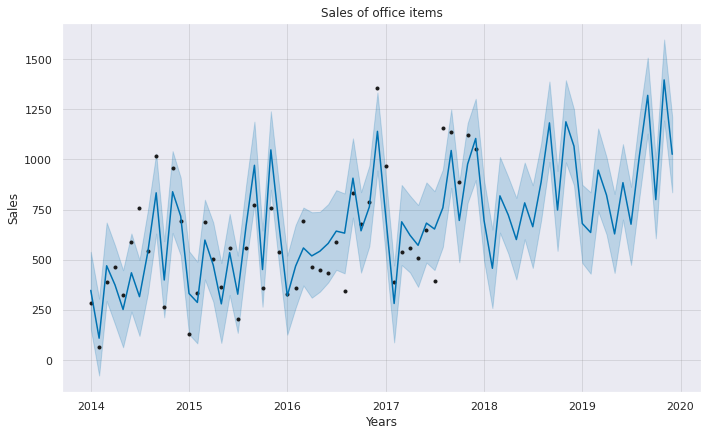

In [131]:
m_office.plot(forecast_office)
plt.title('Sales of office items')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()

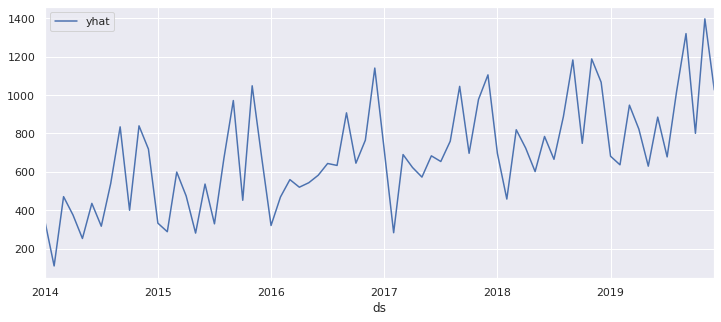

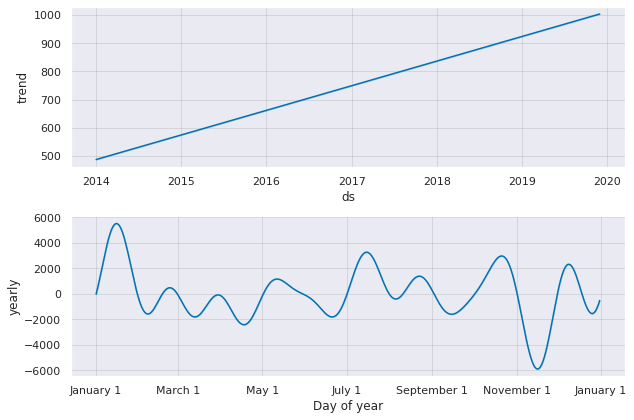

In [132]:
plot_plotly(m_office, forecast_office)
forecast_office.plot(x='ds',y='yhat',figsize=(12,5))

m_office.plot_components(forecast_office);

####Note:
 - From trend plot, a linearly increasing trend is observed for the sales of office items, which indicates increasing demand of office items for the next few years.
 - Higher seasonality is observed on mid of january and lower seasonality on Mid of November.

In [133]:
plot_components_plotly(m_office, forecast_office)

Higher seasonality on January 16 and lowest on November 15 is predicted.

###Technology

In [134]:
y_technology_df = y_technology.to_frame()
y_technology_df['ds'] = y_technology_df.index
y_technology_df.columns = ['y','ds']
y_technology_df

y         ds
Order Date                        
2014-01-01   449.041429 2014-01-01
2014-02-01   229.787143 2014-02-01
2014-03-01  2031.948375 2014-03-01
2014-04-01   613.028933 2014-04-01
2014-05-01   564.698588 2014-05-01
2014-06-01   766.905909 2014-06-01
2014-07-01   533.608933 2014-07-01
2014-08-01   708.435385 2014-08-01
2014-09-01  2035.838133 2014-09-01
2014-10-01   596.900900 2014-10-01
2014-11-01  1208.056320 2014-11-01
2014-12-01  1160.732889 2014-12-01
2015-01-01   925.070800 2015-01-01
2015-02-01   431.121250 2015-02-01
2015-03-01   574.662333 2015-03-01
2015-04-01   697.559500 2015-04-01
2015-05-01   831.642857 2015-05-01
2015-06-01   429.024400 2015-06-01
2015-07-01   691.397733 2015-07-01
2015-08-01  1108.902286 2015-08-01
2015-09-01   950.856400 2015-09-01
2015-10-01   594.716111 2015-10-01
2015-11-01  1037.982652 2015-11-01
2015-12-01  1619.637636 2015-12-01
2016-01-01   374.671067 2016-01-01
2016-02-01  1225.891400 2016-02-01
2016-03-01  1135.150105 2016-03-01
2016-04-01   875.911882 2016-04-01
2016-05-01  1601.816167 2016-05-01
2016-06-01  1023.259500 2016-06-01
2016-07-01   829.312500 2016-07-01
2016-08-01   483.620100 2016-08-01
2016-09-01  1144.170300 2016-09-01
2016-10-01  1970.835875 2016-10-01
2016-11-01  1085.642360 2016-11-01
2016-12-01   970.554870 2016-12-01
2017-01-01  1195.218071 2017-01-01
2017-02-01   430.501714 2017-02-01
2017-03-01  1392.859250 2017-03-01
2017-04-01   825.559133 2017-04-01
2017-05-01   678.329400 2017-05-01
2017-06-01   853.055000 2017-06-01
2017-07-01  1054.996636 2017-07-01
2017-08-01   978.842333 2017-08-01
2017-09-01  1077.704120 2017-09-01
2017-10-01  1493.439227 2017-10-01
2017-11-01  1996.750920 2017-11-01
2017-12-01   955.865652 2017-12-01

In [141]:
m_technology = Prophet()

m_technology.fit(y_technology_df)

future_technology = m_technology.make_future_dataframe(periods=24,freq='MS')

future_technology

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/xsubuky1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrhxh9c_/rmjfm1yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2348', 'data', 'file=/tmp/tmphrhxh9c_/xsubuky1.json', 'init=/tmp/tmphrhxh9c_/rmjfm1yc.json', 'output', 'file=/tmp/tmphrhxh9c_/prophet_modelzw15_0fd/prophet_model-20221112192005.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
0  2014-01-01
1  2014-02-01
2  2014-03-01
3  2014-04-01
4  2014-05-01
..        ...
67 2019-08-01
68 2019-09-01
69 2019-10-01
70 2019-11-01
71 2019-12-01

[72 rows x 1 columns]

In [142]:
forecast_technology = m_technology.predict(future_technology)
forecast_technology

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2014-01-01   952.354900   179.304827  1272.828960   952.354900   
1  2014-02-01   958.476047  -226.482918   936.432716   958.476047   
2  2014-03-01   964.004826   606.126929  1688.792968   964.004826   
3  2014-04-01   970.125973   115.137467  1182.487094   970.125973   
4  2014-05-01   976.049665   211.608245  1288.489878   976.049665   
..        ...          ...          ...          ...          ...   
67 2019-08-01  1354.771136   973.316824  2021.343071  1354.771052   
68 2019-09-01  1360.892286  1210.181511  2276.164535  1360.892197   
69 2019-10-01  1366.815980   227.720553  1336.199001  1366.815885   
70 2019-11-01  1372.937131   933.103380  2035.953377  1372.937028   
71 2019-12-01  1378.860825  1247.046923  2326.456899  1378.860714   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    952.354900     -220.563518           -220.563518           -220.563518   
1    958.476047     -613.862382           -613.862382           -613.862382   
2    964.004826      181.796373            181.796373            181.796373   
3    970.125973     -328.518998           -328.518998           -328.518998   
4    976.049665     -237.337621           -237.337621           -237.337621   
..          ...             ...                   ...                   ...   
67  1354.771220      135.985179            135.985179            135.985179   
68  1360.892376      399.279074            399.279074            399.279074   
69  1366.816076     -585.315817           -585.315817           -585.315817   
70  1372.937230      150.386727            150.386727            150.386727   
71  1378.860929      411.780124            411.780124            411.780124   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -220.563518   -220.563518   -220.563518                   0.0   
1  -613.862382   -613.862382   -613.862382                   0.0   
2   181.796373    181.796373    181.796373                   0.0   
3  -328.518998   -328.518998   -328.518998                   0.0   
4  -237.337621   -237.337621   -237.337621                   0.0   
..         ...           ...           ...                   ...   
67  135.985179    135.985179    135.985179                   0.0   
68  399.279074    399.279074    399.279074                   0.0   
69 -585.315817   -585.315817   -585.315817                   0.0   
70  150.386727    150.386727    150.386727                   0.0   
71  411.780124    411.780124    411.780124                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0   731.791382  
1                          0.0                         0.0   344.613664  
2                          0.0                         0.0  1145.801199  
3                          0.0                         0.0   641.606975  
4                          0.0                         0.0   738.712044  
..                         ...                         ...          ...  
67                         0.0                         0.0  1490.756315  
68                         0.0                         0.0  1760.171360  
69                         0.0                         0.0   781.500163  
70                         0.0                         0.0  1523.323857  
71                         0.0                         0.0  1790.640949  

[72 rows x 16 columns]

In [143]:
forecast_technology.columns

forecast_technology[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

ds   yhat_lower   yhat_upper         yhat
60 2019-01-01   344.885785  1420.385198   883.358664
61 2019-02-01   375.774065  1533.680561   955.919737
62 2019-03-01   910.755771  1960.730367  1438.844567
63 2019-04-01   438.125518  1526.803653   991.802707
64 2019-05-01   385.711088  1501.264351   955.702668
65 2019-06-01   380.132583  1465.096437   924.215829
66 2019-07-01   555.391914  1588.981898  1083.808482
67 2019-08-01   973.316824  2021.343071  1490.756315
68 2019-09-01  1210.181511  2276.164535  1760.171360
69 2019-10-01   227.720553  1336.199001   781.500163
70 2019-11-01   933.103380  2035.953377  1523.323857
71 2019-12-01  1247.046923  2326.456899  1790.640949

Text(48.5, 0.5, 'Sales')

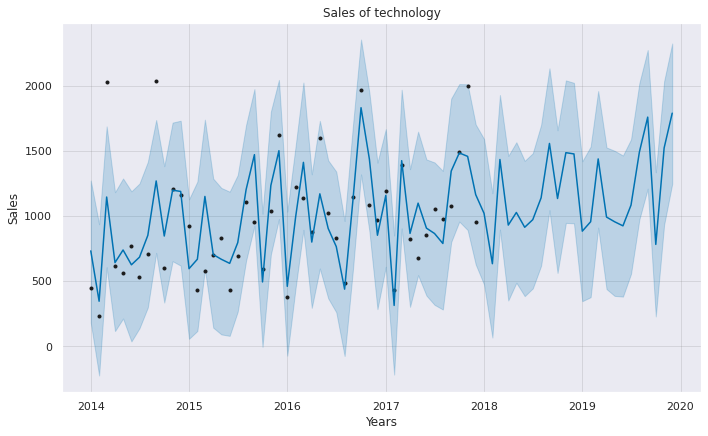

In [144]:
m_technology.plot(forecast_technology);
plt.title('Sales of technology')
plt.xlabel('Years')
plt.ylabel('Sales')

 - From the graph, Higher sales was observed in the year 2016 during month of August-september in 2016.
 - Lower sales in 2018 is predicted on december and in 2019 it is predicted on October, which indicate lesser demand for these months.

Sales of technology products is predicted as same as previous years.

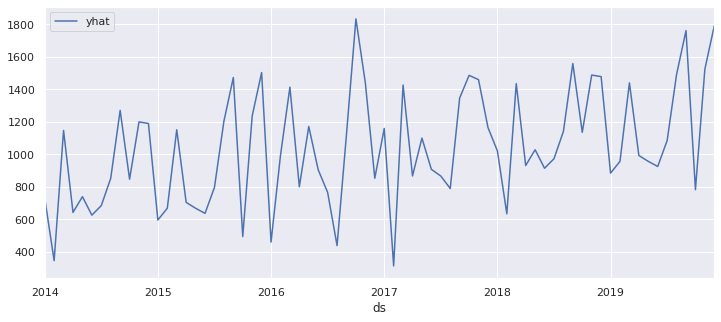

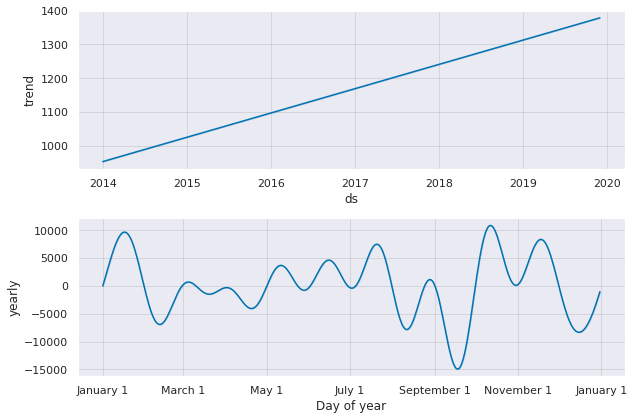

In [145]:
plot_plotly(m_technology, forecast_technology)
forecast_technology.plot(x='ds',y='yhat',figsize=(12,5))
m_technology.plot_components(forecast_technology);

In [146]:
plot_components_plotly(m_technology, forecast_technology)

A increasing trend in sales is expected for technology items eventhough their sales are comparatively higher than other product categories.

 - high seasonality is expected on mid october and mid january.
 - lower seasonality on middle of september is predicted.

####Note:
 - Demand of office items is increasing as predicted from the above graphs.
 - Trend of technology items linearly increasing over years so demand of products is decreasing.
 - Demand of furniture items is predicted as steadily increasing.

##Conclusion:
 - Demand of office items is increasing as predicted by SARIMA model and Fbprophet.
 - Demand of furniture items is predicted as steadily increasing.
 - Somewhat constant trend in sales for technology items is observed. but it have comparatively large amount of sales.
Suitable Business strategies have to be implemented to improve sales of product category furniture.